# California housing 

## import delle librerie

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
import optuna

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

## caricamento del dataset

In [93]:
housing = fetch_california_housing()

df = pd.DataFrame(housing.data, columns = housing.feature_names)
df['MedHouseVal'] = housing.target

In [94]:
df.head()

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  MedHouseVal  
0    -122.23        4.526  
1    -122.22        3.585  
2    -122.24        3.521  
3    -122.25        3.413  
4    -122.25        3.422

## Pulizia del dataset

In [95]:
# pulizia delle colonne 
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

# Rinominare per coerenza
df = df.rename(columns={
    "medinc": "med_inc",
    "houseage": "house_age",
    "averooms": "ave_rooms",
    "avebedrms": "ave_bedrms",
    "aveoccup": "ave_occup",
    "medhouseval": "med_house_val"
})

# Quick check
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   med_inc        20640 non-null  float64
 1   house_age      20640 non-null  float64
 2   ave_rooms      20640 non-null  float64
 3   ave_bedrms     20640 non-null  float64
 4   population     20640 non-null  float64
 5   ave_occup      20640 non-null  float64
 6   latitude       20640 non-null  float64
 7   longitude      20640 non-null  float64
 8   med_house_val  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB
None


In [96]:
# check del dataset 
print("=== Controllo valori mancanti ===")
print(df.isnull().sum(), "\n")

print("=== Tipi di dato ===")
print(df.dtypes, "\n")

=== Controllo valori mancanti ===
med_inc          0
house_age        0
ave_rooms        0
ave_bedrms       0
population       0
ave_occup        0
latitude         0
longitude        0
med_house_val    0
dtype: int64 

=== Tipi di dato ===
med_inc          float64
house_age        float64
ave_rooms        float64
ave_bedrms       float64
population       float64
ave_occup        float64
latitude         float64
longitude        float64
med_house_val    float64
dtype: object 



In [97]:
# outlier detection
num_features = ['med_inc', 'house_age', 'ave_rooms', 'ave_bedrms', 'population', 'ave_occup', 'med_house_val']

def get_outlier_mask(dataframe, cols=num_features, k=1.5):
    mask = pd.DataFrame(False, index=dataframe.index, columns=cols)
    for col in cols:
        q1 = dataframe[col].quantile(0.25)
        q3 = dataframe[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - k*iqr
        upper = q3 + k*iqr
        mask[col] = (dataframe[col] < lower) | (dataframe[col] > upper)
    return mask.any(axis=1)

before_count = df.shape[0]
mask = get_outlier_mask(df)
df = df[~mask].dropna()
after_count = df.shape[0]

print(f"Prima della rimozione degli outlier: {before_count} righe")
print(f"Dopo la rimozione degli outlier: {after_count} righe\n")



Prima della rimozione degli outlier: 20640 righe
Dopo la rimozione degli outlier: 16312 righe



## Feature Engineering

In [98]:
# Punti di ancoraggio per il fit quadratico
_LAT = np.array([41.8, 39.0, 37.7, 36.6, 34.4, 34.0, 32.7])
_LON = np.array([-124.2, -123.7, -122.5, -121.9, -120.3, -118.5, -117.2])
_COAST_COEFFS = np.polyfit(_LAT, _LON, deg=2)

def _coast_lon(lat):
    a, b, c = _COAST_COEFFS
    # lon = a*lat^2 + b*lat + c
    return a*lat*lat + b*lat + c

def classify_location(lat, lon):
    # Calcola la longitudine prevista della costa a questa latitudine
    coast_at_lat = _coast_lon(lat)

    # Buffer per definire la "coast" (entro 1 grado ad est della curva)
    coast_buffer = 1

    # Soglia per l'interno: 2.3 gradi di longitudine ad est della curva della costa
    inland_shift = 2.3
    inland_at_lat = coast_at_lat + inland_shift

    if lon <= coast_at_lat + coast_buffer:
        return "coast"
    elif lon >= inland_at_lat:
        return "inland"
    else:
        return "middle"

# Applica la classificazione avanzata
df["position"] = df.apply(lambda row: classify_location(row['latitude'], row['longitude']), axis=1)


# Feature Engineering: Popolazione per Cella (Densità Locale)
def add_population_per_cell(df, lat_col="latitude", lon_col="longitude", pop_col="population",
                            lat_bin=0.1, lon_bin=0.1):
    df = df.copy()
    # Crea bins
    df["_lat_bin"] = (df[lat_col] // lat_bin) * lat_bin
    df["_lon_bin"] = (df[lon_col] // lon_bin) * lon_bin
    
    # Aggrega la popolazione per bin
    pop_map = (
        df.groupby(["_lat_bin", "_lon_bin"])[pop_col]
        .sum()
        .reset_index()
        .rename(columns={pop_col: "pop_per_cell"})
    )
    
    # Unisci
    df = df.merge(pop_map, on=["_lat_bin", "_lon_bin"], how="left")
    return df.drop(columns=["_lat_bin", "_lon_bin"])

df = add_population_per_cell(df)

print("\nColonne dopo il Feature Engineering:")
print(df.columns)
print(df[['position', 'pop_per_cell']].head())


Colonne dopo il Feature Engineering:
Index(['med_inc', 'house_age', 'ave_rooms', 'ave_bedrms', 'population',
       'ave_occup', 'latitude', 'longitude', 'med_house_val', 'position',
       'pop_per_cell'],
      dtype='object')
  position  pop_per_cell
0    coast      227421.0
1    coast      227421.0
2    coast      227421.0
3    coast      227421.0
4    coast      227421.0


In [99]:
print(df.columns)

Index(['med_inc', 'house_age', 'ave_rooms', 'ave_bedrms', 'population',
       'ave_occup', 'latitude', 'longitude', 'med_house_val', 'position',
       'pop_per_cell'],
      dtype='object')


## Pairplot

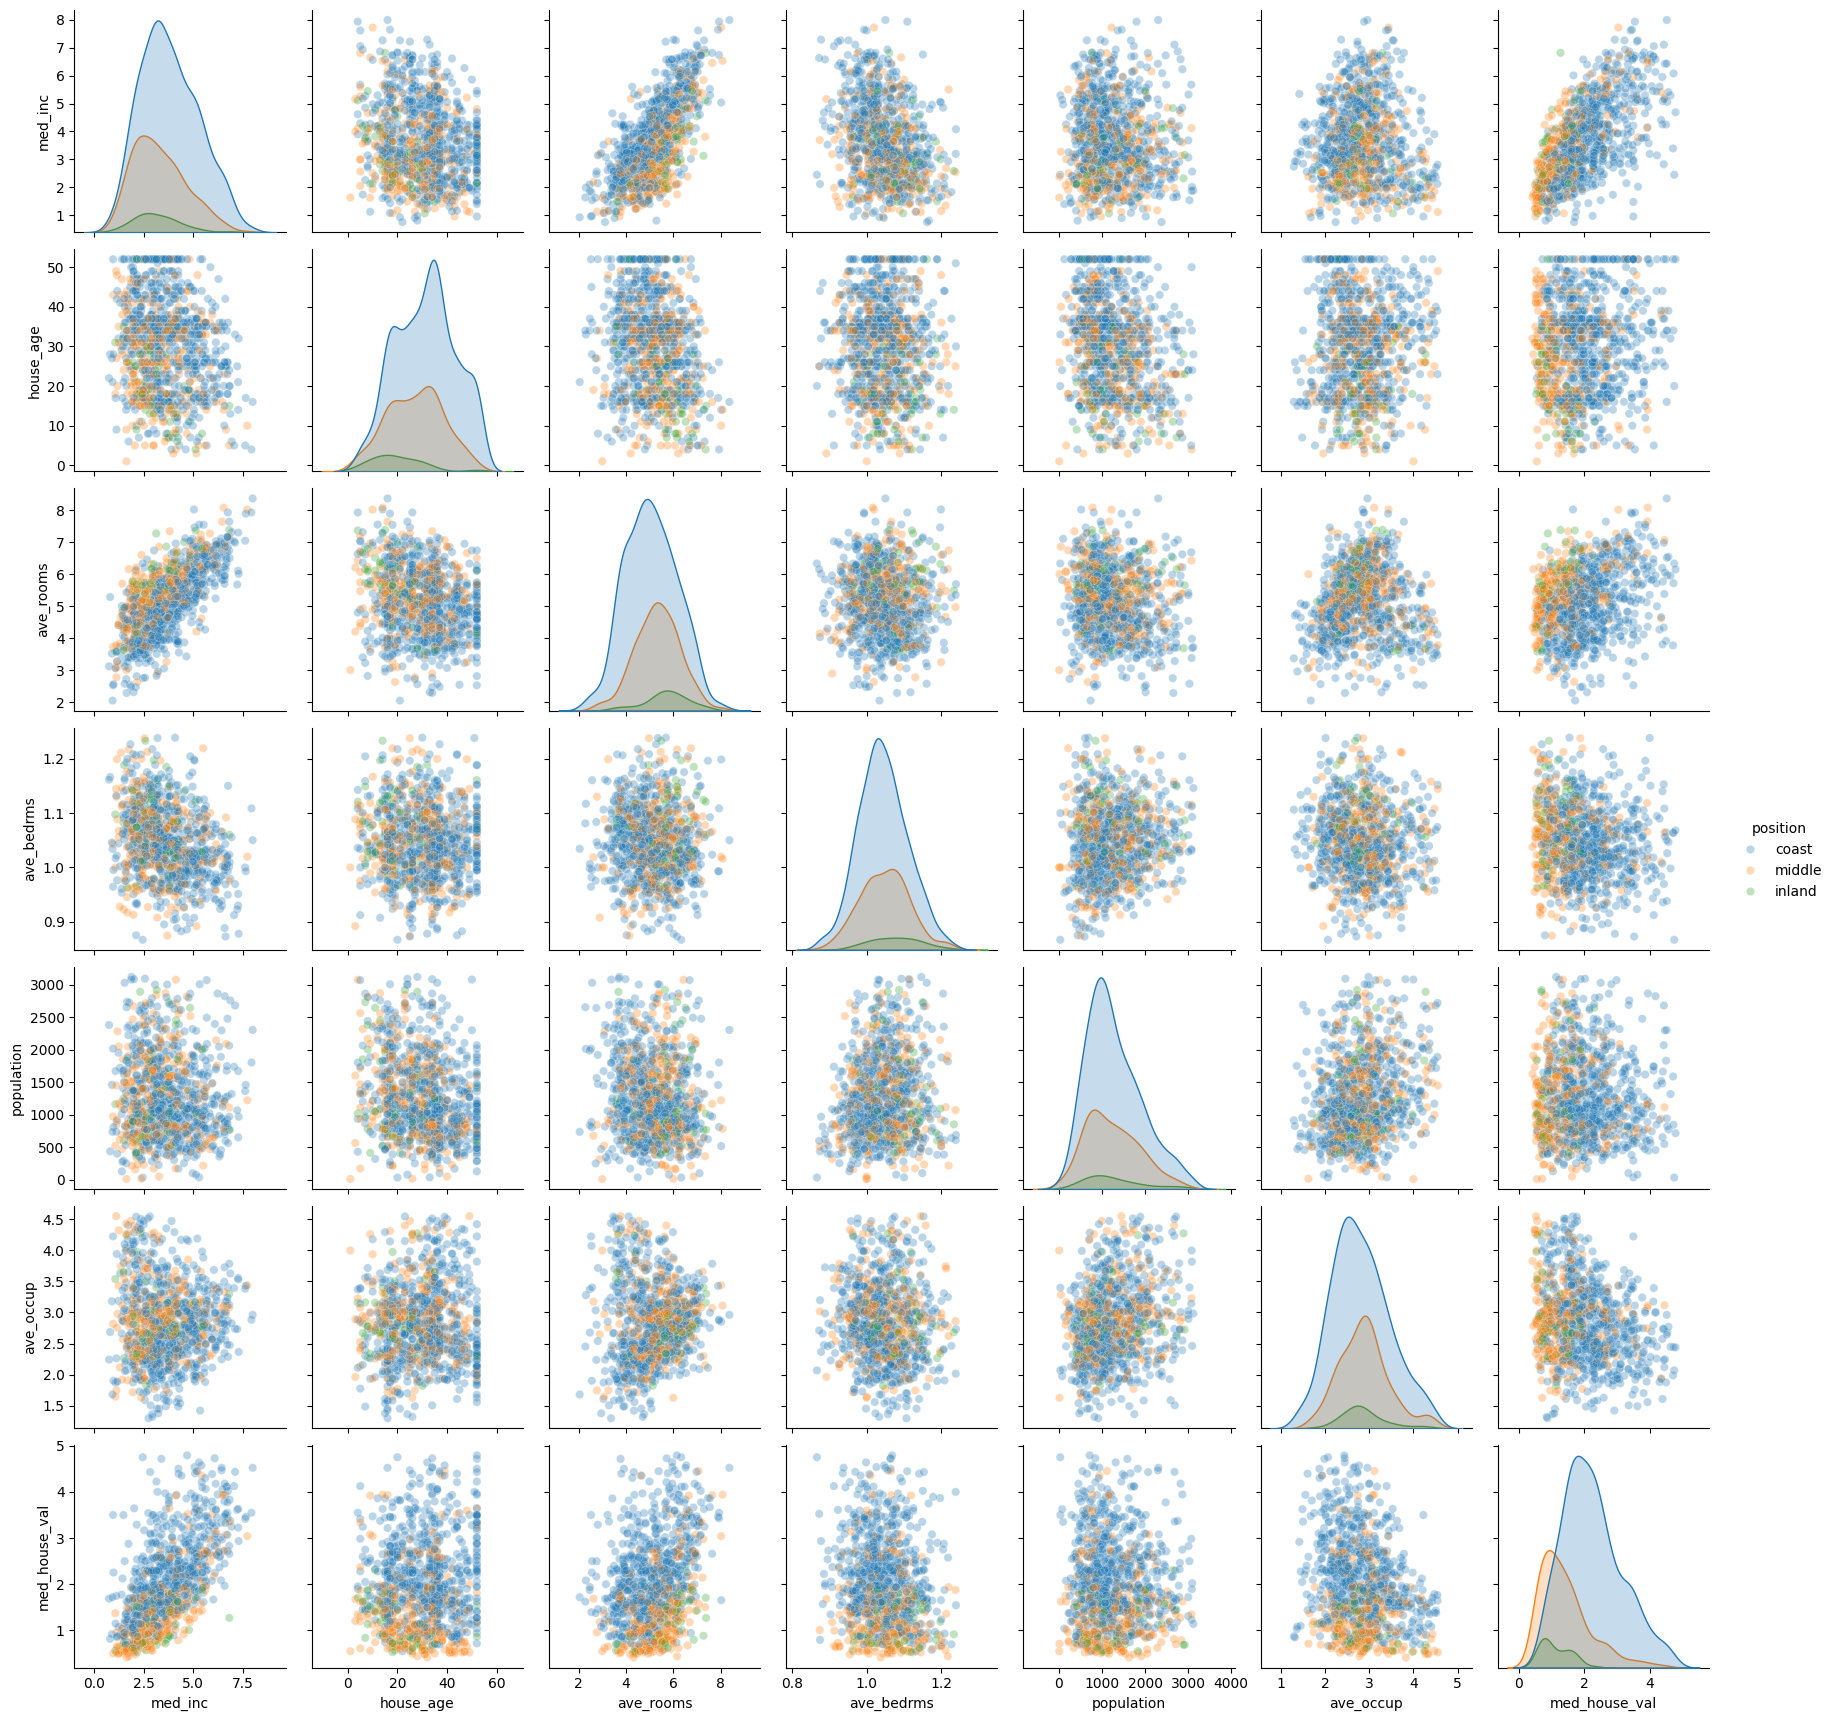

In [100]:
sample_df = df.sample(1000, random_state=42)

sns.pairplot(
    sample_df,
    vars=num_features,
    hue="position",
    diag_kind="kde",
    plot_kws={"alpha":0.3}
)
plt.show()

### Matrice di correlazione

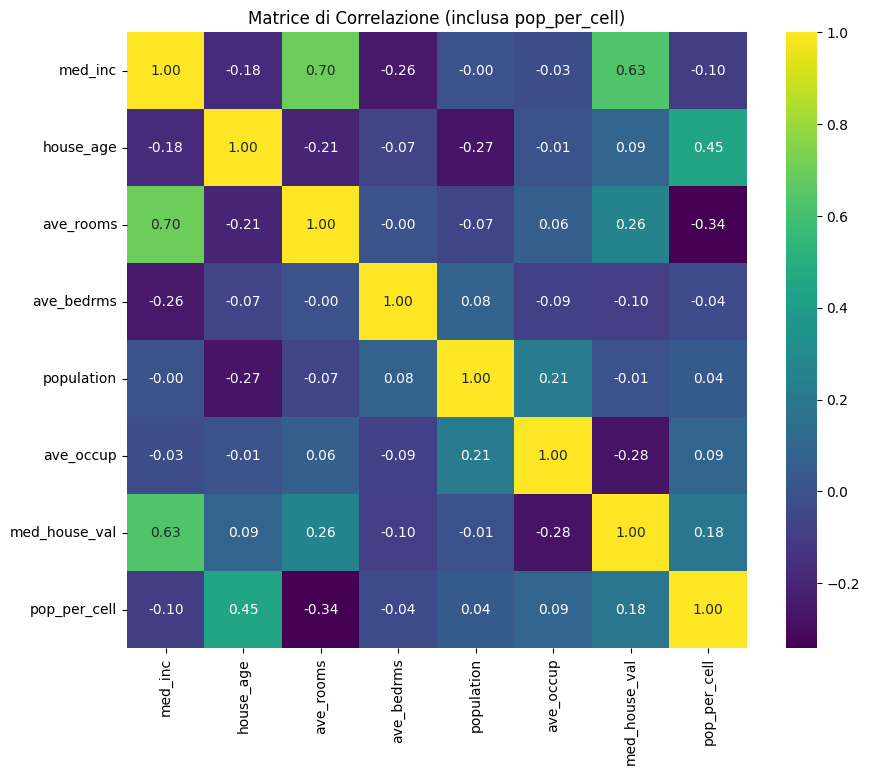

In [101]:
tmp = df[num_features + ["pop_per_cell"]].copy()
corr = tmp.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="viridis")
plt.title("Matrice di Correlazione (inclusa pop_per_cell)")
plt.show()

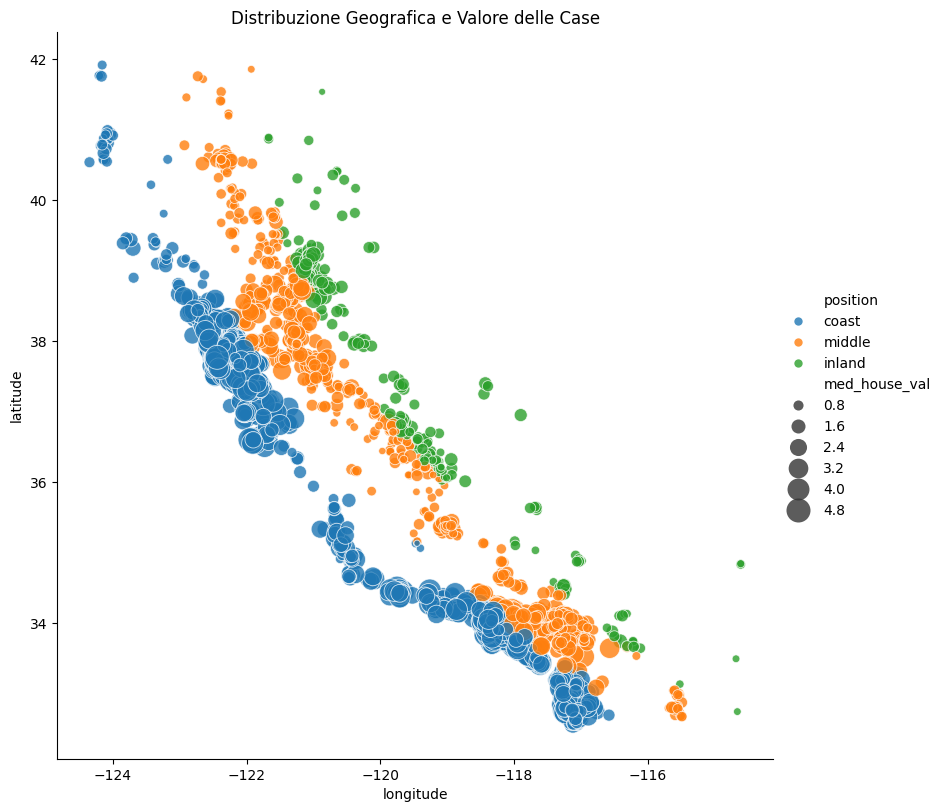

In [102]:
# visualizzazione geografica
sns.relplot(
    data=df.sample(5000, random_state=42),
    x="longitude",
    y="latitude",
    hue="position",
    size="med_house_val",
    sizes=(20, 300),
    alpha=.8,
    height=8
)
plt.title("Distribuzione Geografica e Valore delle Case")
plt.show()

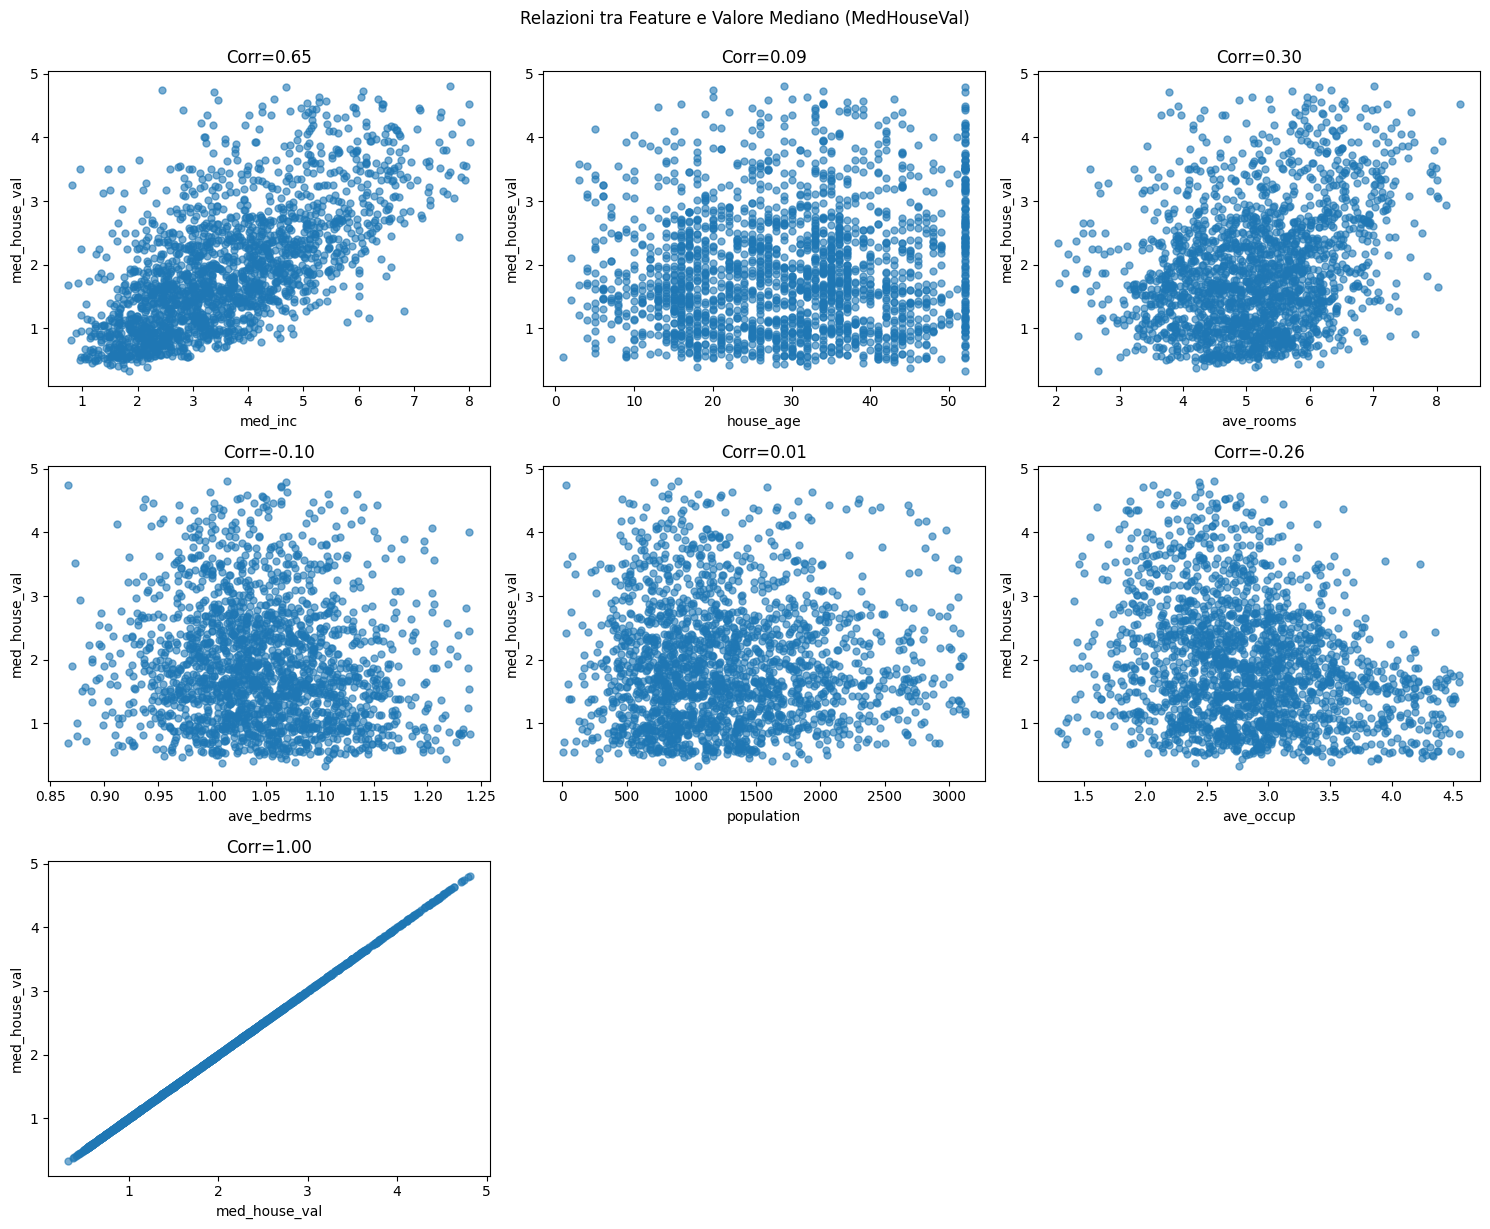

In [103]:
cols = num_features
target = "med_house_val"

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

sample_df = df.sample(2000, random_state=42)

for i, col in enumerate(cols):
    axes[i].plot(sample_df[col], sample_df[target], 'o', markersize=5, alpha=0.6)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel(target)
    # Commento automatico
    corr_val = sample_df[col].corr(sample_df[target])
    axes[i].set_title(f"Corr={corr_val:.2f}")

# Nascondi assi inutilizzati
for j in range(len(cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Relazioni tra Feature e Valore Mediano (MedHouseVal)", y=1.02)
plt.show()

## Suddivisione feature e target

In [106]:
X = df.drop(columns = ['med_house_val']) 
y = df["med_house_val"]

In [107]:
# Rimuoviamo la colonna 'position' se presente
X_numeric = X.drop(columns=['position'], errors='ignore')  

# Standardizzazione
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

# Creiamo un DataFrame per ispezione 
X_scaled_df = pd.DataFrame(X_scaled, columns=X_numeric.columns)

print("Shape dataset standardizzato:", X_scaled_df.shape)
X_scaled_df.head()


Shape dataset standardizzato: (16312, 9)


med_inc  house_age  ave_rooms  ave_bedrms  population  ave_occup  \
0  2.491677    1.84949   3.001399    0.393891   -1.236573  -0.100659   
1  1.374203    1.84949   0.633741    0.388078   -1.137747  -0.507620   
2  0.130327    1.84949   1.078856    0.508584   -1.126589  -1.094067   
3  0.262267    1.84949  -0.377889    0.847278   -1.368872  -1.160590   
4  0.000810    1.84949  -0.214746   -1.440116   -0.283381  -1.178979   

   latitude  longitude  pop_per_cell  
0  1.017985  -1.309756      0.800758  
1  1.017985  -1.314768      0.800758  
2  1.017985  -1.314768      0.800758  
3  1.017985  -1.314768      0.800758  
4  1.013313  -1.314768      0.800758

In [108]:
# Divisione train/test (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

print(f"Train set: {len(X_train)} campioni | Test set: {len(X_test)} campioni")



Train set: 13049 campioni | Test set: 3263 campioni


## Training e valutazione dei modelli 


In [109]:
models = [
    ("Linear Regression", LinearRegression()),
    ("Random Forest", RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)),
    ("KNN Regressor", KNeighborsRegressor(n_neighbors=5))
]


Linear Regression:
  R² Score:  0.644
  RMSE:      0.558
  MAE:       0.420
  MSE:       0.311


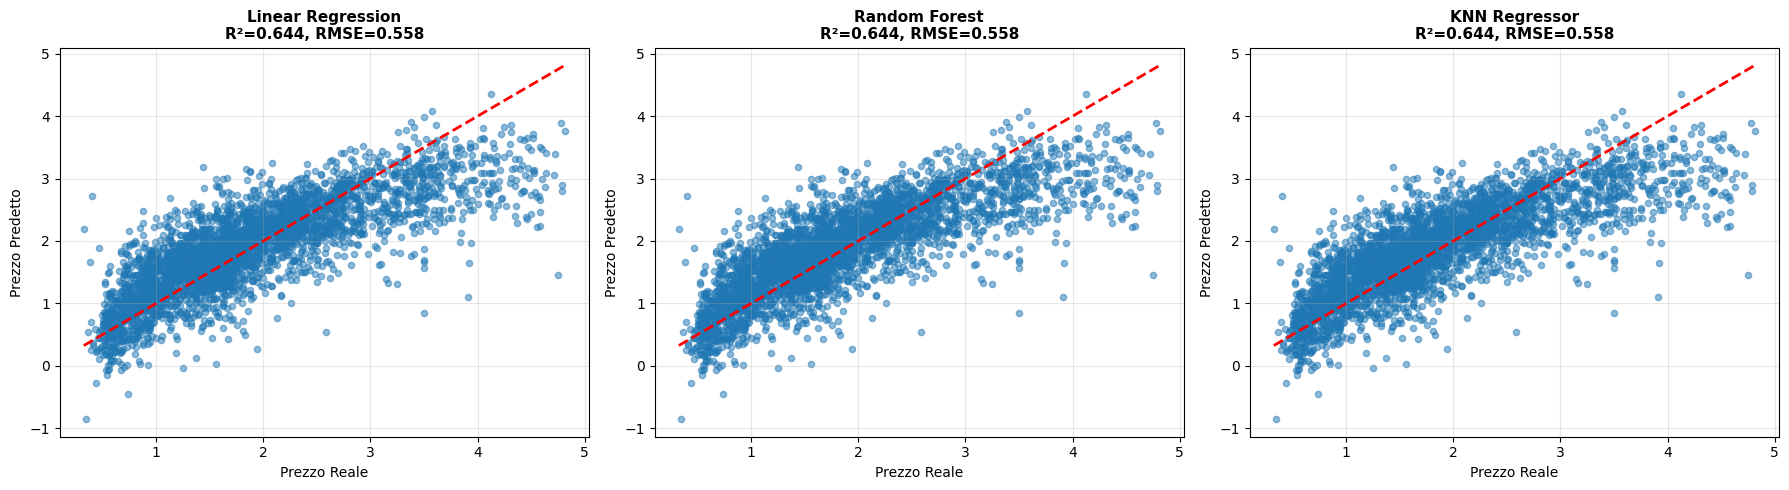


Random Forest:
  R² Score:  0.765
  RMSE:      0.454
  MAE:       0.321
  MSE:       0.206


<Figure size 640x480 with 0 Axes>


KNN Regressor:
  R² Score:  0.667
  RMSE:      0.539
  MAE:       0.384
  MSE:       0.291


<Figure size 640x480 with 0 Axes>

In [110]:
results = []

fig, axes = plt.subplots(1, 3, figsize=(18, 5)) 
axes = axes.flatten()

for idx, (name, model) in enumerate(models):
    # Training
    model.fit(X_train, y_train)
    
    # Predizione
    y_pred = model.predict(X_test)
    
    # Metriche
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Salvo risultati
    results.append({
        'Modello': name,
        'R²': r2,
        'RMSE': rmse,
        'MAE': mae,
        'MSE': mse
    })
    
    # Stampo metriche
    print(f"\n{name}:")
    print(f"  R² Score:  {r2:.3f}")
    print(f"  RMSE:      {rmse:.3f}")
    print(f"  MAE:       {mae:.3f}")
    print(f"  MSE:       {mse:.3f}")
    
    
    axes = axes.flatten()
    
    for idx, (name, model) in enumerate(models):
        ax = axes[idx]
        ax.scatter(y_test, y_pred, alpha=0.5, s=20)
        ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        ax.set_xlabel("Prezzo Reale", fontsize=10)
        ax.set_ylabel("Prezzo Predetto", fontsize=10)
        ax.set_title(f"{name}\nR²={r2:.3f}, RMSE={rmse:.3f}", fontsize=11, fontweight='bold')
        ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()
    

In [112]:
from sklearn.model_selection import GridSearchCV
print("\n\n--- OTTIMIZZAZIONE XGBOOST CON GRID SEARCH ---")

# Parametri da testare (ridotti per tempi di esecuzione ragionevoli)
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [3, 6],
    'learning_rate': [0.1, 0.05]
}

xgb_model = XGBRegressor(random_state=42, objective='reg:squarederror')

# Utilizziamo MSE negativo come metrica (sklearn ottimizza i punteggi più alti)
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3, # 3-fold cross validation
    verbose=1,
    n_jobs=-1 # Usa tutti i core disponibili
)

grid_search.fit(X_train, y_train)

# 4. Valutazione del Modello Ottimizzato
best_xgb = grid_search.best_estimator_
print('Best params (grid):', grid_search.best_params_)


# Evaluate grid best
y_pred_grid = best_xgb.predict(X_test)
print('Grid XGB R2:', r2_score(y_test, y_pred_grid))




--- OTTIMIZZAZIONE XGBOOST CON GRID SEARCH ---
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best params (grid): {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300}
Grid XGB R2: 0.8447486021582509


## Optuna hyperparameter tuning for XGBOOST

In [113]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import xgboost as xgb
import optuna
import numpy as np

In [114]:
def optuna_ob(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 2, 12),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
        'random_state': 42,
        'objective': 'reg:squarederror',
        'n_jobs': -1
    }
    
    model = XGBRegressor(**param)
    
    cv = KFold(n_splits=3, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
    
    mse_mean = -np.mean(scores)  # Trasforma in positivo
    print(f"Trial {trial.number} - MSE medio: {mse_mean:.4f}")
    
    #  negativo del MSE
    return -mse_mean
    

### Casi studio di optuna

In [115]:
from xgboost.callback import EarlyStopping

In [117]:
study = optuna.create_study(direction='maximize')
study.optimize(optuna_ob, n_trials=100, show_progress_bar=True)

print('Best optuna params (raw):', study.best_params)

# -----------------------------
# Build modello XGB con i parametri ottimali
# -----------------------------
best_params = study.best_params.copy()
# Rimozione parametri duplicati o non necessari
best_params.pop('random_state', None)

best_xgb_optuna = XGBRegressor(
    **best_params,
    objective='reg:squarederror',
    eval_metric='rmse',
    random_state=42,
    n_jobs=-1
)

# -----------------------------
# Split train/validation per early stopping
# -----------------------------
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# -----------------------------
# Fit con early stopping
# -----------------------------
early_stopping = EarlyStopping(
    rounds=30, 
    save_best=True
)

# fit del modello
best_xgb_optuna.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],
   # callbacks=[early_stopping] 
)


[I 2025-12-09 15:10:56,327] A new study created in memory with name: no-name-4ec460ba-bcf6-4ae2-a118-93d315080ae0
  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\Rosy\AppData\Local\Temp\ipykernel_19432\951964047.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\Rosy\AppData\Local\Temp\ipykernel_19432\951964047.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\Rosy\AppData\Local\Temp\ipykernel_19432\951964047.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/o

Trial 0 - MSE medio: 0.1845
[I 2025-12-09 15:11:06,213] Trial 0 finished with value: -0.1844591882941291 and parameters: {'n_estimators': 624, 'max_depth': 12, 'learning_rate': 0.1035296857893636, 'subsample': 0.7014192599403535, 'colsample_bytree': 0.4517569215340988, 'reg_alpha': 0.33283857365557207, 'reg_lambda': 3.6607291639497807e-07}. Best is trial 0 with value: -0.1844591882941291.


Best trial: 0. Best value: -0.184459:   2%|▏         | 2/100 [00:13<10:04,  6.17s/it]

Trial 1 - MSE medio: 0.2000
[I 2025-12-09 15:11:09,775] Trial 1 finished with value: -0.20003258964310952 and parameters: {'n_estimators': 80, 'max_depth': 11, 'learning_rate': 0.03857719564427395, 'subsample': 0.9474421588468247, 'colsample_bytree': 0.475156060019814, 'reg_alpha': 2.7716133938632467e-08, 'reg_lambda': 2.0258250066068982e-05}. Best is trial 0 with value: -0.1844591882941291.


Best trial: 2. Best value: -0.157709:   3%|▎         | 3/100 [00:17<08:32,  5.29s/it]

Trial 2 - MSE medio: 0.1577
[I 2025-12-09 15:11:14,016] Trial 2 finished with value: -0.15770860977306653 and parameters: {'n_estimators': 688, 'max_depth': 7, 'learning_rate': 0.05483225025526228, 'subsample': 0.5546281736780103, 'colsample_bytree': 0.47280800775823295, 'reg_alpha': 0.0016826366381333493, 'reg_lambda': 2.0652265319522755e-08}. Best is trial 2 with value: -0.15770860977306653.


Best trial: 2. Best value: -0.157709:   4%|▍         | 4/100 [00:23<08:33,  5.35s/it]

Trial 3 - MSE medio: 0.2546
[I 2025-12-09 15:11:19,450] Trial 3 finished with value: -0.2545861026522215 and parameters: {'n_estimators': 717, 'max_depth': 12, 'learning_rate': 0.27672744105332264, 'subsample': 0.8794764275972621, 'colsample_bytree': 0.4809251141610045, 'reg_alpha': 9.677160280120578e-08, 'reg_lambda': 2.2388996631000393e-07}. Best is trial 2 with value: -0.15770860977306653.


Best trial: 2. Best value: -0.157709:   5%|▌         | 5/100 [00:23<05:39,  3.57s/it]

Trial 4 - MSE medio: 0.1951
[I 2025-12-09 15:11:19,877] Trial 4 finished with value: -0.19513359458682442 and parameters: {'n_estimators': 145, 'max_depth': 3, 'learning_rate': 0.13224306653945575, 'subsample': 0.6159539042428364, 'colsample_bytree': 0.6880487921125369, 'reg_alpha': 0.011277040085548072, 'reg_lambda': 0.000124206259653385}. Best is trial 2 with value: -0.15770860977306653.


Best trial: 2. Best value: -0.157709:   6%|▌         | 6/100 [00:25<04:35,  2.93s/it]

Trial 5 - MSE medio: 0.1944
[I 2025-12-09 15:11:21,558] Trial 5 finished with value: -0.19438858225513425 and parameters: {'n_estimators': 387, 'max_depth': 5, 'learning_rate': 0.013848796358587446, 'subsample': 0.5231331067305143, 'colsample_bytree': 0.7847163240626249, 'reg_alpha': 0.013526435669627822, 'reg_lambda': 2.268157885030735e-05}. Best is trial 2 with value: -0.15770860977306653.


Best trial: 2. Best value: -0.157709:   7%|▋         | 7/100 [00:25<03:16,  2.11s/it]

Trial 6 - MSE medio: 0.2416
[I 2025-12-09 15:11:21,992] Trial 6 finished with value: -0.2415801176655832 and parameters: {'n_estimators': 189, 'max_depth': 2, 'learning_rate': 0.08284553002791076, 'subsample': 0.563604145977139, 'colsample_bytree': 0.5199931061602201, 'reg_alpha': 1.4378942265323274e-06, 'reg_lambda': 2.3773472595467187}. Best is trial 2 with value: -0.15770860977306653.


Best trial: 2. Best value: -0.157709:   8%|▊         | 8/100 [00:32<05:41,  3.71s/it]

Trial 7 - MSE medio: 0.1714
[I 2025-12-09 15:11:29,131] Trial 7 finished with value: -0.1714389035871979 and parameters: {'n_estimators': 764, 'max_depth': 7, 'learning_rate': 0.1659561499177569, 'subsample': 0.8305086673605031, 'colsample_bytree': 0.9238207164982073, 'reg_alpha': 4.991350260636914e-05, 'reg_lambda': 4.112779890698605e-08}. Best is trial 2 with value: -0.15770860977306653.


Best trial: 2. Best value: -0.157709:   9%|▉         | 9/100 [00:34<04:28,  2.95s/it]

Trial 8 - MSE medio: 0.1912
[I 2025-12-09 15:11:30,394] Trial 8 finished with value: -0.19120572793683613 and parameters: {'n_estimators': 684, 'max_depth': 2, 'learning_rate': 0.08832316709106135, 'subsample': 0.6248697858104684, 'colsample_bytree': 0.45839176021116146, 'reg_alpha': 5.305999636968473e-05, 'reg_lambda': 2.7904205205836646e-05}. Best is trial 2 with value: -0.15770860977306653.


Best trial: 2. Best value: -0.157709:  10%|█         | 10/100 [00:41<06:23,  4.26s/it]

Trial 9 - MSE medio: 0.1590
[I 2025-12-09 15:11:37,587] Trial 9 finished with value: -0.15895209247179767 and parameters: {'n_estimators': 383, 'max_depth': 10, 'learning_rate': 0.053468089377500395, 'subsample': 0.6325570051328795, 'colsample_bytree': 0.8752819943717326, 'reg_alpha': 2.218933605034931, 'reg_lambda': 9.020010504806745e-05}. Best is trial 2 with value: -0.15770860977306653.


Best trial: 10. Best value: -0.151571:  11%|█         | 11/100 [00:51<09:02,  6.09s/it]

Trial 10 - MSE medio: 0.1516
[I 2025-12-09 15:11:47,829] Trial 10 finished with value: -0.1515707187059943 and parameters: {'n_estimators': 989, 'max_depth': 8, 'learning_rate': 0.025086214377665682, 'subsample': 0.7535839672302279, 'colsample_bytree': 0.6266013302914113, 'reg_alpha': 0.0021109276913193788, 'reg_lambda': 0.02876290908675353}. Best is trial 10 with value: -0.1515707187059943.


Best trial: 11. Best value: -0.150939:  12%|█▏        | 12/100 [01:01<10:43,  7.32s/it]

Trial 11 - MSE medio: 0.1509
[I 2025-12-09 15:11:57,949] Trial 11 finished with value: -0.15093914830225383 and parameters: {'n_estimators': 998, 'max_depth': 8, 'learning_rate': 0.023586513994534857, 'subsample': 0.7562573858468353, 'colsample_bytree': 0.6238614611629888, 'reg_alpha': 0.004455005553798564, 'reg_lambda': 0.05333035522944395}. Best is trial 11 with value: -0.15093914830225383.


Best trial: 11. Best value: -0.150939:  13%|█▎        | 13/100 [01:16<14:03,  9.70s/it]

Trial 12 - MSE medio: 0.1527
[I 2025-12-09 15:12:13,138] Trial 12 finished with value: -0.15274211256029485 and parameters: {'n_estimators': 993, 'max_depth': 9, 'learning_rate': 0.017970417849878285, 'subsample': 0.771770817585094, 'colsample_bytree': 0.6189704472372679, 'reg_alpha': 0.11915008973598387, 'reg_lambda': 0.178863559824701}. Best is trial 11 with value: -0.15093914830225383.


Best trial: 11. Best value: -0.150939:  14%|█▍        | 14/100 [01:26<13:58,  9.75s/it]

Trial 13 - MSE medio: 0.1516
[I 2025-12-09 15:12:22,985] Trial 13 finished with value: -0.15157658932483967 and parameters: {'n_estimators': 996, 'max_depth': 8, 'learning_rate': 0.025506314268637812, 'subsample': 0.743928104207994, 'colsample_bytree': 0.6204891160776985, 'reg_alpha': 0.00044168347778995116, 'reg_lambda': 0.013538253007180404}. Best is trial 11 with value: -0.15093914830225383.


Best trial: 11. Best value: -0.150939:  15%|█▌        | 15/100 [01:29<10:55,  7.71s/it]

Trial 14 - MSE medio: 0.1591
[I 2025-12-09 15:12:25,974] Trial 14 finished with value: -0.15914335759955764 and parameters: {'n_estimators': 872, 'max_depth': 5, 'learning_rate': 0.024839996111480956, 'subsample': 0.8147161075946702, 'colsample_bytree': 0.5850620688754471, 'reg_alpha': 8.070929454155497e-06, 'reg_lambda': 0.00579991422936379}. Best is trial 11 with value: -0.15093914830225383.


Best trial: 11. Best value: -0.150939:  16%|█▌        | 16/100 [01:42<13:04,  9.33s/it]

Trial 15 - MSE medio: 0.1570
[I 2025-12-09 15:12:39,087] Trial 15 finished with value: -0.1570374539651894 and parameters: {'n_estimators': 858, 'max_depth': 9, 'learning_rate': 0.011750808307288543, 'subsample': 0.7268708740121237, 'colsample_bytree': 0.7277884972928746, 'reg_alpha': 0.006798636567514498, 'reg_lambda': 8.229694311506197}. Best is trial 11 with value: -0.15093914830225383.


Best trial: 11. Best value: -0.150939:  17%|█▋        | 17/100 [01:46<10:26,  7.55s/it]

Trial 16 - MSE medio: 0.1571
[I 2025-12-09 15:12:42,474] Trial 16 finished with value: -0.1571310220624242 and parameters: {'n_estimators': 874, 'max_depth': 5, 'learning_rate': 0.029683445760253124, 'subsample': 0.9107616630143087, 'colsample_bytree': 0.8109340672751573, 'reg_alpha': 0.15473652019350814, 'reg_lambda': 0.0027336355251730655}. Best is trial 11 with value: -0.15093914830225383.


Best trial: 11. Best value: -0.150939:  18%|█▊        | 18/100 [01:48<08:21,  6.12s/it]

Trial 17 - MSE medio: 0.1746
[I 2025-12-09 15:12:45,268] Trial 17 finished with value: -0.1745698619465658 and parameters: {'n_estimators': 509, 'max_depth': 6, 'learning_rate': 0.01656642374874388, 'subsample': 0.6830896084076085, 'colsample_bytree': 0.6859446176102095, 'reg_alpha': 4.205870962419836, 'reg_lambda': 0.16200106166573908}. Best is trial 11 with value: -0.15093914830225383.


Best trial: 11. Best value: -0.150939:  19%|█▉        | 19/100 [02:02<11:20,  8.40s/it]

Trial 18 - MSE medio: 0.1555
[I 2025-12-09 15:12:58,992] Trial 18 finished with value: -0.15553770082617416 and parameters: {'n_estimators': 915, 'max_depth': 9, 'learning_rate': 0.04356986533281721, 'subsample': 0.8111593928756591, 'colsample_bytree': 0.5691862075352464, 'reg_alpha': 0.00042225487349170534, 'reg_lambda': 0.2940255471572283}. Best is trial 11 with value: -0.15093914830225383.


Best trial: 11. Best value: -0.150939:  20%|██        | 20/100 [02:13<12:10,  9.13s/it]

Trial 19 - MSE medio: 0.1622
[I 2025-12-09 15:13:09,819] Trial 19 finished with value: -0.16219390804594092 and parameters: {'n_estimators': 787, 'max_depth': 8, 'learning_rate': 0.019375473460822065, 'subsample': 0.9941859035982951, 'colsample_bytree': 0.9950617620645597, 'reg_alpha': 4.586894363359706e-05, 'reg_lambda': 0.0013593360701435351}. Best is trial 11 with value: -0.15093914830225383.


Best trial: 11. Best value: -0.150939:  21%|██        | 21/100 [02:23<12:21,  9.39s/it]

Trial 20 - MSE medio: 0.1843
[I 2025-12-09 15:13:19,823] Trial 20 finished with value: -0.1842895339448959 and parameters: {'n_estimators': 540, 'max_depth': 10, 'learning_rate': 0.01114700756023201, 'subsample': 0.7794141650561405, 'colsample_bytree': 0.40368669292406417, 'reg_alpha': 0.0024778560281083577, 'reg_lambda': 0.05820045632744148}. Best is trial 11 with value: -0.15093914830225383.


Best trial: 11. Best value: -0.150939:  22%|██▏       | 22/100 [02:33<12:24,  9.54s/it]

Trial 21 - MSE medio: 0.1511
[I 2025-12-09 15:13:29,714] Trial 21 finished with value: -0.15113876119345207 and parameters: {'n_estimators': 1000, 'max_depth': 8, 'learning_rate': 0.02639152818149808, 'subsample': 0.7303194379342759, 'colsample_bytree': 0.6282018500281364, 'reg_alpha': 0.0004445531905552553, 'reg_lambda': 0.015599209735441995}. Best is trial 11 with value: -0.15093914830225383.


Best trial: 22. Best value: -0.15047:  23%|██▎       | 23/100 [02:42<12:09,  9.48s/it] 

Trial 22 - MSE medio: 0.1505
[I 2025-12-09 15:13:39,037] Trial 22 finished with value: -0.15046999249529877 and parameters: {'n_estimators': 954, 'max_depth': 8, 'learning_rate': 0.031780517786417044, 'subsample': 0.670822406432392, 'colsample_bytree': 0.6456730825957466, 'reg_alpha': 0.060641157736269574, 'reg_lambda': 0.019268419123969552}. Best is trial 22 with value: -0.15046999249529877.


Best trial: 22. Best value: -0.15047:  24%|██▍       | 24/100 [02:49<11:03,  8.73s/it]

Trial 23 - MSE medio: 0.1527
[I 2025-12-09 15:13:46,015] Trial 23 finished with value: -0.1527117824215343 and parameters: {'n_estimators': 928, 'max_depth': 7, 'learning_rate': 0.035814522069676995, 'subsample': 0.6687538948593414, 'colsample_bytree': 0.7468556190066054, 'reg_alpha': 0.06083267329179155, 'reg_lambda': 0.00048029092743757023}. Best is trial 22 with value: -0.15046999249529877.


Best trial: 22. Best value: -0.15047:  25%|██▌       | 25/100 [02:53<09:13,  7.38s/it]

Trial 24 - MSE medio: 0.1544
[I 2025-12-09 15:13:50,262] Trial 24 finished with value: -0.15442687675394473 and parameters: {'n_estimators': 813, 'max_depth': 6, 'learning_rate': 0.06190111542106497, 'subsample': 0.6569227339454204, 'colsample_bytree': 0.6694691355986012, 'reg_alpha': 0.028343235728180885, 'reg_lambda': 0.8295781184114969}. Best is trial 22 with value: -0.15046999249529877.


Best trial: 22. Best value: -0.15047:  26%|██▌       | 26/100 [03:06<10:57,  8.88s/it]

Trial 25 - MSE medio: 0.1561
[I 2025-12-09 15:14:02,641] Trial 25 finished with value: -0.15605660290385961 and parameters: {'n_estimators': 932, 'max_depth': 10, 'learning_rate': 0.03319949824283325, 'subsample': 0.7213032869350817, 'colsample_bytree': 0.5443552808386428, 'reg_alpha': 0.8843936779830808, 'reg_lambda': 0.028235987120811695}. Best is trial 22 with value: -0.15046999249529877.


Best trial: 22. Best value: -0.15047:  27%|██▋       | 27/100 [03:10<09:04,  7.46s/it]

Trial 26 - MSE medio: 0.1559
[I 2025-12-09 15:14:06,775] Trial 26 finished with value: -0.15586508130093732 and parameters: {'n_estimators': 816, 'max_depth': 6, 'learning_rate': 0.01967126760339766, 'subsample': 0.8585371076399108, 'colsample_bytree': 0.6452792009588167, 'reg_alpha': 0.00016719213934325526, 'reg_lambda': 0.0007938494271471993}. Best is trial 22 with value: -0.15046999249529877.


Best trial: 22. Best value: -0.15047:  28%|██▊       | 28/100 [03:19<09:27,  7.89s/it]

Trial 27 - MSE medio: 0.1542
[I 2025-12-09 15:14:15,667] Trial 27 finished with value: -0.15417850171000388 and parameters: {'n_estimators': 913, 'max_depth': 8, 'learning_rate': 0.04837552253277505, 'subsample': 0.5855119214743071, 'colsample_bytree': 0.5885276449623911, 'reg_alpha': 1.5967669580531472e-06, 'reg_lambda': 0.006549790538887265}. Best is trial 22 with value: -0.15046999249529877.


Best trial: 22. Best value: -0.15047:  29%|██▉       | 29/100 [03:20<07:06,  6.01s/it]

Trial 28 - MSE medio: 0.1616
[I 2025-12-09 15:14:17,291] Trial 28 finished with value: -0.1615915447963245 and parameters: {'n_estimators': 572, 'max_depth': 4, 'learning_rate': 0.06544423334170833, 'subsample': 0.6898847072602071, 'colsample_bytree': 0.729250770124673, 'reg_alpha': 0.0020850189914437467, 'reg_lambda': 0.7904236213827367}. Best is trial 22 with value: -0.15046999249529877.


Best trial: 22. Best value: -0.15047:  30%|███       | 30/100 [03:28<07:26,  6.38s/it]

Trial 29 - MSE medio: 0.1775
[I 2025-12-09 15:14:24,524] Trial 29 finished with value: -0.17751574917625035 and parameters: {'n_estimators': 320, 'max_depth': 11, 'learning_rate': 0.014405664949845472, 'subsample': 0.7046121544555433, 'colsample_bytree': 0.5222439550094786, 'reg_alpha': 0.6685346051804385, 'reg_lambda': 0.07596126478086866}. Best is trial 22 with value: -0.15046999249529877.


Best trial: 22. Best value: -0.15047:  31%|███       | 31/100 [03:33<06:47,  5.91s/it]

Trial 30 - MSE medio: 0.1566
[I 2025-12-09 15:14:29,337] Trial 30 finished with value: -0.15657557147262988 and parameters: {'n_estimators': 603, 'max_depth': 7, 'learning_rate': 0.0220472732027965, 'subsample': 0.7826142092504234, 'colsample_bytree': 0.7797163405018532, 'reg_alpha': 0.16235699990194447, 'reg_lambda': 1.2830292016876135e-06}. Best is trial 22 with value: -0.15046999249529877.


Best trial: 22. Best value: -0.15047:  32%|███▏      | 32/100 [03:42<07:58,  7.04s/it]

Trial 31 - MSE medio: 0.1512
[I 2025-12-09 15:14:39,027] Trial 31 finished with value: -0.15121353087437528 and parameters: {'n_estimators': 995, 'max_depth': 8, 'learning_rate': 0.028806748021342116, 'subsample': 0.7653770853478538, 'colsample_bytree': 0.6347327715059723, 'reg_alpha': 0.0010149121215791586, 'reg_lambda': 0.02620694304890646}. Best is trial 22 with value: -0.15046999249529877.


Best trial: 22. Best value: -0.15047:  33%|███▎      | 33/100 [03:56<10:13,  9.16s/it]

Trial 32 - MSE medio: 0.1534
[I 2025-12-09 15:14:53,114] Trial 32 finished with value: -0.15335810296602323 and parameters: {'n_estimators': 999, 'max_depth': 9, 'learning_rate': 0.03139242498285868, 'subsample': 0.7396106478999732, 'colsample_bytree': 0.6653495386275711, 'reg_alpha': 0.00023884394242709473, 'reg_lambda': 0.009906423600420582}. Best is trial 22 with value: -0.15046999249529877.


Best trial: 22. Best value: -0.15047:  34%|███▍      | 34/100 [04:05<10:03,  9.15s/it]

Trial 33 - MSE medio: 0.1537
[I 2025-12-09 15:15:02,254] Trial 33 finished with value: -0.15370404877430274 and parameters: {'n_estimators': 945, 'max_depth': 8, 'learning_rate': 0.0373643388605045, 'subsample': 0.6530724343510206, 'colsample_bytree': 0.5983937201908778, 'reg_alpha': 0.02988025181238834, 'reg_lambda': 0.001707254086356257}. Best is trial 22 with value: -0.15046999249529877.


Best trial: 22. Best value: -0.15047:  35%|███▌      | 35/100 [04:29<14:43, 13.59s/it]

Trial 34 - MSE medio: 0.1595
[I 2025-12-09 15:15:26,186] Trial 34 finished with value: -0.15949514159706044 and parameters: {'n_estimators': 847, 'max_depth': 11, 'learning_rate': 0.028140411195159813, 'subsample': 0.7130118843114535, 'colsample_bytree': 0.6529524623666563, 'reg_alpha': 0.0006962173085915182, 'reg_lambda': 0.8339177359248813}. Best is trial 22 with value: -0.15046999249529877.


Best trial: 22. Best value: -0.15047:  36%|███▌      | 36/100 [04:39<13:11, 12.37s/it]

Trial 35 - MSE medio: 0.1590
[I 2025-12-09 15:15:35,721] Trial 35 finished with value: -0.15899717267791588 and parameters: {'n_estimators': 760, 'max_depth': 9, 'learning_rate': 0.04253999781578341, 'subsample': 0.8550995911594863, 'colsample_bytree': 0.5547682452036901, 'reg_alpha': 0.004562493266413608, 'reg_lambda': 0.00021651103330579602}. Best is trial 22 with value: -0.15046999249529877.


Best trial: 22. Best value: -0.15047:  37%|███▋      | 37/100 [04:44<10:39, 10.15s/it]

Trial 36 - MSE medio: 0.1588
[I 2025-12-09 15:15:40,703] Trial 36 finished with value: -0.15884004942134367 and parameters: {'n_estimators': 658, 'max_depth': 7, 'learning_rate': 0.014875176442358772, 'subsample': 0.797254192653771, 'colsample_bytree': 0.699534232581973, 'reg_alpha': 1.0467341176122737e-08, 'reg_lambda': 0.03651709711952161}. Best is trial 22 with value: -0.15046999249529877.


Best trial: 22. Best value: -0.15047:  38%|███▊      | 38/100 [05:00<12:26, 12.03s/it]

Trial 37 - MSE medio: 0.1569
[I 2025-12-09 15:15:57,122] Trial 37 finished with value: -0.15690986130644935 and parameters: {'n_estimators': 946, 'max_depth': 10, 'learning_rate': 0.021394584550064086, 'subsample': 0.7641297609200435, 'colsample_bytree': 0.5096839207087581, 'reg_alpha': 1.1654962509697511e-05, 'reg_lambda': 2.9409634673450737}. Best is trial 22 with value: -0.15046999249529877.


Best trial: 22. Best value: -0.15047:  39%|███▉      | 39/100 [05:06<10:13, 10.06s/it]

Trial 38 - MSE medio: 0.1545
[I 2025-12-09 15:16:02,589] Trial 38 finished with value: -0.15452596337577687 and parameters: {'n_estimators': 739, 'max_depth': 7, 'learning_rate': 0.03828799326588243, 'subsample': 0.5960627271293967, 'colsample_bytree': 0.7165702008974807, 'reg_alpha': 0.012541229930121234, 'reg_lambda': 0.003717535584375318}. Best is trial 22 with value: -0.15046999249529877.


Best trial: 22. Best value: -0.15047:  40%|████      | 40/100 [05:10<08:21,  8.36s/it]

Trial 39 - MSE medio: 0.1534
[I 2025-12-09 15:16:06,966] Trial 39 finished with value: -0.15344959382705417 and parameters: {'n_estimators': 873, 'max_depth': 6, 'learning_rate': 0.0693705636304477, 'subsample': 0.8427188534754209, 'colsample_bytree': 0.7532825523298299, 'reg_alpha': 0.00010916108182942194, 'reg_lambda': 3.838653422912218e-06}. Best is trial 22 with value: -0.15046999249529877.


Best trial: 22. Best value: -0.15047:  41%|████      | 41/100 [05:11<05:58,  6.08s/it]

Trial 40 - MSE medio: 0.2350
[I 2025-12-09 15:16:07,740] Trial 40 finished with value: -0.235039899518204 and parameters: {'n_estimators': 85, 'max_depth': 8, 'learning_rate': 0.2878514985055557, 'subsample': 0.5029447733333043, 'colsample_bytree': 0.4947513273630187, 'reg_alpha': 0.0009373089393682546, 'reg_lambda': 0.01409651623654521}. Best is trial 22 with value: -0.15046999249529877.


Best trial: 22. Best value: -0.15047:  42%|████▏     | 42/100 [05:20<06:50,  7.07s/it]

Trial 41 - MSE medio: 0.1513
[I 2025-12-09 15:16:17,110] Trial 41 finished with value: -0.15129742610998267 and parameters: {'n_estimators': 998, 'max_depth': 8, 'learning_rate': 0.024068600777583982, 'subsample': 0.7542910960645769, 'colsample_bytree': 0.6313172264053785, 'reg_alpha': 0.003781526455295408, 'reg_lambda': 0.10894685977198143}. Best is trial 22 with value: -0.15046999249529877.


Best trial: 22. Best value: -0.15047:  43%|████▎     | 43/100 [05:27<06:31,  6.86s/it]

Trial 42 - MSE medio: 0.1508
[I 2025-12-09 15:16:23,486] Trial 42 finished with value: -0.15078873015018027 and parameters: {'n_estimators': 944, 'max_depth': 7, 'learning_rate': 0.022454020349576123, 'subsample': 0.6952532181418279, 'colsample_bytree': 0.6283528052675267, 'reg_alpha': 0.03353905629758023, 'reg_lambda': 0.26360842321181477}. Best is trial 22 with value: -0.15046999249529877.


Best trial: 22. Best value: -0.15047:  44%|████▍     | 44/100 [05:33<06:17,  6.73s/it]

Trial 43 - MSE medio: 0.1510
[I 2025-12-09 15:16:29,928] Trial 43 finished with value: -0.15103671067104693 and parameters: {'n_estimators': 944, 'max_depth': 7, 'learning_rate': 0.028678465660975854, 'subsample': 0.6382609767410757, 'colsample_bytree': 0.6060967432235315, 'reg_alpha': 0.02821711601667074, 'reg_lambda': 0.4076973225757455}. Best is trial 22 with value: -0.15046999249529877.


Best trial: 22. Best value: -0.15047:  45%|████▌     | 45/100 [05:38<05:43,  6.25s/it]

Trial 44 - MSE medio: 0.1785
[I 2025-12-09 15:16:35,032] Trial 44 finished with value: -0.17849679654124948 and parameters: {'n_estimators': 950, 'max_depth': 6, 'learning_rate': 0.21528533835865335, 'subsample': 0.6379584891420689, 'colsample_bytree': 0.6006477639836814, 'reg_alpha': 0.02467514439062328, 'reg_lambda': 0.3168539087402376}. Best is trial 22 with value: -0.15046999249529877.


Best trial: 22. Best value: -0.15047:  46%|████▌     | 46/100 [05:44<05:33,  6.17s/it]

Trial 45 - MSE medio: 0.1564
[I 2025-12-09 15:16:41,032] Trial 45 finished with value: -0.15640259703869344 and parameters: {'n_estimators': 888, 'max_depth': 7, 'learning_rate': 0.016124147557829326, 'subsample': 0.5557019990690157, 'colsample_bytree': 0.5556894212572864, 'reg_alpha': 0.5043223981463096, 'reg_lambda': 4.415487891683323}. Best is trial 22 with value: -0.15046999249529877.


Best trial: 22. Best value: -0.15047:  47%|████▋     | 47/100 [05:58<07:20,  8.32s/it]

Trial 46 - MSE medio: 0.1540
[I 2025-12-09 15:16:54,353] Trial 46 finished with value: -0.15404391969638317 and parameters: {'n_estimators': 818, 'max_depth': 9, 'learning_rate': 0.021633279205188195, 'subsample': 0.6106110076125321, 'colsample_bytree': 0.6905508466729978, 'reg_alpha': 0.07571248418420769, 'reg_lambda': 0.5247395616480004}. Best is trial 22 with value: -0.15046999249529877.


Best trial: 22. Best value: -0.15047:  48%|████▊     | 48/100 [05:59<05:33,  6.41s/it]

Trial 47 - MSE medio: 0.1580
[I 2025-12-09 15:16:56,322] Trial 47 finished with value: -0.15798069184002914 and parameters: {'n_estimators': 712, 'max_depth': 4, 'learning_rate': 0.1267402692157375, 'subsample': 0.695223357887533, 'colsample_bytree': 0.6085558614195181, 'reg_alpha': 0.008092530853178462, 'reg_lambda': 2.2427830612784514}. Best is trial 22 with value: -0.15046999249529877.


Best trial: 22. Best value: -0.15047:  49%|████▉     | 49/100 [06:01<04:13,  4.98s/it]

Trial 48 - MSE medio: 0.1860
[I 2025-12-09 15:16:57,959] Trial 48 finished with value: -0.18600150886909772 and parameters: {'n_estimators': 464, 'max_depth': 5, 'learning_rate': 0.02619952568301162, 'subsample': 0.6833424271966103, 'colsample_bytree': 0.5332494715034873, 'reg_alpha': 8.23912694022176, 'reg_lambda': 0.13745705821812754}. Best is trial 22 with value: -0.15046999249529877.


Best trial: 22. Best value: -0.15047:  50%|█████     | 50/100 [06:07<04:27,  5.35s/it]

Trial 49 - MSE medio: 0.1551
[I 2025-12-09 15:17:04,187] Trial 49 finished with value: -0.1551112651754308 and parameters: {'n_estimators': 899, 'max_depth': 7, 'learning_rate': 0.013153498276544771, 'subsample': 0.6619877398614238, 'colsample_bytree': 0.5794535902122222, 'reg_alpha': 0.234704611245161, 'reg_lambda': 6.0540404584357796e-05}. Best is trial 22 with value: -0.15046999249529877.


Best trial: 22. Best value: -0.15047:  51%|█████     | 51/100 [06:09<03:24,  4.17s/it]

Trial 50 - MSE medio: 0.1655
[I 2025-12-09 15:17:05,604] Trial 50 finished with value: -0.1654641739437661 and parameters: {'n_estimators': 226, 'max_depth': 6, 'learning_rate': 0.048217566142596605, 'subsample': 0.7321117318135328, 'colsample_bytree': 0.8434613605405326, 'reg_alpha': 0.053982443459275255, 'reg_lambda': 1.3687039179257194}. Best is trial 22 with value: -0.15046999249529877.


Best trial: 51. Best value: -0.150398:  52%|█████▏    | 52/100 [06:18<04:29,  5.62s/it]

Trial 51 - MSE medio: 0.1504
[I 2025-12-09 15:17:14,589] Trial 51 finished with value: -0.1503975618625503 and parameters: {'n_estimators': 962, 'max_depth': 8, 'learning_rate': 0.029232716116096073, 'subsample': 0.7150018329259724, 'colsample_bytree': 0.6363559320180957, 'reg_alpha': 0.0015482817699841252, 'reg_lambda': 0.024187057451079543}. Best is trial 51 with value: -0.1503975618625503.


Best trial: 51. Best value: -0.150398:  53%|█████▎    | 53/100 [06:33<06:42,  8.56s/it]

Trial 52 - MSE medio: 0.1552
[I 2025-12-09 15:17:30,024] Trial 52 finished with value: -0.1551973660132031 and parameters: {'n_estimators': 956, 'max_depth': 9, 'learning_rate': 0.032069991200104724, 'subsample': 0.7093909712393645, 'colsample_bytree': 0.6707254340520536, 'reg_alpha': 0.01747392423936459, 'reg_lambda': 0.0577150238642802}. Best is trial 51 with value: -0.1503975618625503.


Best trial: 51. Best value: -0.150398:  54%|█████▍    | 54/100 [06:43<06:46,  8.84s/it]

Trial 53 - MSE medio: 0.1516
[I 2025-12-09 15:17:39,512] Trial 53 finished with value: -0.15160922450910794 and parameters: {'n_estimators': 958, 'max_depth': 8, 'learning_rate': 0.017242712811652655, 'subsample': 0.6401741422772661, 'colsample_bytree': 0.6475525760371473, 'reg_alpha': 0.007801163724080713, 'reg_lambda': 0.21921150939673686}. Best is trial 51 with value: -0.1503975618625503.


Best trial: 51. Best value: -0.150398:  55%|█████▌    | 55/100 [06:48<05:55,  7.90s/it]

Trial 54 - MSE medio: 0.1519
[I 2025-12-09 15:17:45,224] Trial 54 finished with value: -0.15187589538863946 and parameters: {'n_estimators': 849, 'max_depth': 7, 'learning_rate': 0.025171208134078808, 'subsample': 0.6805459612205899, 'colsample_bytree': 0.6199080291029225, 'reg_alpha': 1.7069022320665859, 'reg_lambda': 0.011318693778707856}. Best is trial 51 with value: -0.1503975618625503.


Best trial: 51. Best value: -0.150398:  56%|█████▌    | 56/100 [06:58<06:12,  8.48s/it]

Trial 55 - MSE medio: 0.1524
[I 2025-12-09 15:17:55,040] Trial 55 finished with value: -0.15236467601238943 and parameters: {'n_estimators': 903, 'max_depth': 8, 'learning_rate': 0.019498354865370934, 'subsample': 0.6161850620319771, 'colsample_bytree': 0.6795812011903921, 'reg_alpha': 0.0018797976411718826, 'reg_lambda': 0.3801850865458658}. Best is trial 51 with value: -0.1503975618625503.


Best trial: 51. Best value: -0.150398:  57%|█████▋    | 57/100 [07:07<06:13,  8.68s/it]

Trial 56 - MSE medio: 0.1525
[I 2025-12-09 15:18:04,201] Trial 56 finished with value: -0.15251455144830983 and parameters: {'n_estimators': 960, 'max_depth': 8, 'learning_rate': 0.03405710690765354, 'subsample': 0.5780135274431525, 'colsample_bytree': 0.5655553748968024, 'reg_alpha': 0.04682879174239889, 'reg_lambda': 0.025052692286479845}. Best is trial 51 with value: -0.1503975618625503.


Best trial: 51. Best value: -0.150398:  58%|█████▊    | 58/100 [07:21<07:02, 10.07s/it]

Trial 57 - MSE medio: 0.1586
[I 2025-12-09 15:18:17,517] Trial 57 finished with value: -0.15856544744597048 and parameters: {'n_estimators': 800, 'max_depth': 9, 'learning_rate': 0.04262407072148814, 'subsample': 0.7369881210748398, 'colsample_bytree': 0.7031798085594717, 'reg_alpha': 8.402928245901843e-05, 'reg_lambda': 0.003741737836423667}. Best is trial 51 with value: -0.1503975618625503.


Best trial: 51. Best value: -0.150398:  59%|█████▉    | 59/100 [07:39<08:29, 12.42s/it]

Trial 58 - MSE medio: 0.1571
[I 2025-12-09 15:18:35,432] Trial 58 finished with value: -0.15706584688049297 and parameters: {'n_estimators': 842, 'max_depth': 10, 'learning_rate': 0.02914583272244901, 'subsample': 0.7981892222696527, 'colsample_bytree': 0.6170430984093271, 'reg_alpha': 2.972216261788813e-05, 'reg_lambda': 0.0813043659213138}. Best is trial 51 with value: -0.1503975618625503.


Best trial: 51. Best value: -0.150398:  60%|██████    | 60/100 [07:45<06:59, 10.48s/it]

Trial 59 - MSE medio: 0.1524
[I 2025-12-09 15:18:41,392] Trial 59 finished with value: -0.15243635619813445 and parameters: {'n_estimators': 912, 'max_depth': 7, 'learning_rate': 0.022363102482794172, 'subsample': 0.7210558234913785, 'colsample_bytree': 0.5798513469657127, 'reg_alpha': 0.00043814538660575357, 'reg_lambda': 9.023154645292827}. Best is trial 51 with value: -0.1503975618625503.


Best trial: 51. Best value: -0.150398:  61%|██████    | 61/100 [07:57<07:07, 10.96s/it]

Trial 60 - MSE medio: 0.1577
[I 2025-12-09 15:18:53,446] Trial 60 finished with value: -0.15770815570656335 and parameters: {'n_estimators': 961, 'max_depth': 9, 'learning_rate': 0.010386796539577732, 'subsample': 0.6774165500933786, 'colsample_bytree': 0.45726142641855794, 'reg_alpha': 0.31727678508047163, 'reg_lambda': 0.000776143442773404}. Best is trial 51 with value: -0.1503975618625503.


Best trial: 51. Best value: -0.150398:  62%|██████▏   | 62/100 [08:06<06:43, 10.61s/it]

Trial 61 - MSE medio: 0.1513
[I 2025-12-09 15:19:03,247] Trial 61 finished with value: -0.15127060462744704 and parameters: {'n_estimators': 987, 'max_depth': 8, 'learning_rate': 0.028913355533598948, 'subsample': 0.7563303098306317, 'colsample_bytree': 0.6298585665534551, 'reg_alpha': 0.0012375633337680146, 'reg_lambda': 0.022212687570744533}. Best is trial 51 with value: -0.1503975618625503.


Best trial: 62. Best value: -0.149934:  63%|██████▎   | 63/100 [08:16<06:25, 10.41s/it]

Trial 62 - MSE medio: 0.1499
[I 2025-12-09 15:19:13,206] Trial 62 finished with value: -0.14993445538920547 and parameters: {'n_estimators': 976, 'max_depth': 8, 'learning_rate': 0.027035664818718375, 'subsample': 0.7819558166171415, 'colsample_bytree': 0.6463689941546693, 'reg_alpha': 0.005312788200486466, 'reg_lambda': 0.03812426365854097}. Best is trial 62 with value: -0.14993445538920547.


Best trial: 62. Best value: -0.149934:  64%|██████▍   | 64/100 [08:23<05:30,  9.19s/it]

Trial 63 - MSE medio: 0.1515
[I 2025-12-09 15:19:19,524] Trial 63 finished with value: -0.15145751900749801 and parameters: {'n_estimators': 925, 'max_depth': 7, 'learning_rate': 0.01822466443751073, 'subsample': 0.8200160085489386, 'colsample_bytree': 0.65520134241377, 'reg_alpha': 0.0036179775516069997, 'reg_lambda': 1.870338128339071e-08}. Best is trial 62 with value: -0.14993445538920547.


Best trial: 62. Best value: -0.149934:  65%|██████▌   | 65/100 [08:32<05:26,  9.34s/it]

Trial 64 - MSE medio: 0.1507
[I 2025-12-09 15:19:29,224] Trial 64 finished with value: -0.15074605609337513 and parameters: {'n_estimators': 973, 'max_depth': 8, 'learning_rate': 0.023274257440068214, 'subsample': 0.7890635569017243, 'colsample_bytree': 0.6018828178731802, 'reg_alpha': 0.016622029987612724, 'reg_lambda': 0.04949209798677547}. Best is trial 62 with value: -0.14993445538920547.


Best trial: 62. Best value: -0.149934:  66%|██████▌   | 66/100 [08:38<04:42,  8.30s/it]

Trial 65 - MSE medio: 0.1507
[I 2025-12-09 15:19:35,103] Trial 65 finished with value: -0.1506505617302488 and parameters: {'n_estimators': 878, 'max_depth': 7, 'learning_rate': 0.023555538640313418, 'subsample': 0.9056766568625516, 'colsample_bytree': 0.596713866115204, 'reg_alpha': 0.11019947873250956, 'reg_lambda': 0.0060462136741306375}. Best is trial 62 with value: -0.14993445538920547.


Best trial: 62. Best value: -0.149934:  67%|██████▋   | 67/100 [08:47<04:40,  8.49s/it]

Trial 66 - MSE medio: 0.1541
[I 2025-12-09 15:19:44,038] Trial 66 finished with value: -0.15410638964413703 and parameters: {'n_estimators': 873, 'max_depth': 8, 'learning_rate': 0.012602795485742639, 'subsample': 0.9308523468625356, 'colsample_bytree': 0.5908031601960217, 'reg_alpha': 0.09971139203304923, 'reg_lambda': 0.008326178176569861}. Best is trial 62 with value: -0.14993445538920547.


Best trial: 62. Best value: -0.149934:  68%|██████▊   | 68/100 [08:51<03:50,  7.21s/it]

Trial 67 - MSE medio: 0.1537
[I 2025-12-09 15:19:48,275] Trial 67 finished with value: -0.1536707425535483 and parameters: {'n_estimators': 889, 'max_depth': 6, 'learning_rate': 0.02297583862999039, 'subsample': 0.9152495602442547, 'colsample_bytree': 0.6528432225895292, 'reg_alpha': 0.01267244410776445, 'reg_lambda': 0.0582303686344868}. Best is trial 62 with value: -0.14993445538920547.


Best trial: 62. Best value: -0.149934:  69%|██████▉   | 69/100 [09:04<04:33,  8.83s/it]

Trial 68 - MSE medio: 0.1571
[I 2025-12-09 15:20:00,883] Trial 68 finished with value: -0.15714867089420673 and parameters: {'n_estimators': 971, 'max_depth': 9, 'learning_rate': 0.016012656812558413, 'subsample': 0.9894930258321546, 'colsample_bytree': 0.5359078991461291, 'reg_alpha': 0.15598631157914403, 'reg_lambda': 0.0020988499603740896}. Best is trial 62 with value: -0.14993445538920547.


Best trial: 62. Best value: -0.149934:  70%|███████   | 70/100 [09:14<04:37,  9.25s/it]

Trial 69 - MSE medio: 0.1522
[I 2025-12-09 15:20:11,113] Trial 69 finished with value: -0.15221701737796772 and parameters: {'n_estimators': 917, 'max_depth': 8, 'learning_rate': 0.02001620796899713, 'subsample': 0.898646051766419, 'colsample_bytree': 0.676640431933187, 'reg_alpha': 0.004320681129540533, 'reg_lambda': 0.005737889337667731}. Best is trial 62 with value: -0.14993445538920547.


Best trial: 62. Best value: -0.149934:  71%|███████   | 71/100 [09:19<03:46,  7.80s/it]

Trial 70 - MSE medio: 0.1607
[I 2025-12-09 15:20:15,537] Trial 70 finished with value: -0.1607033640340317 and parameters: {'n_estimators': 836, 'max_depth': 7, 'learning_rate': 0.03306558979338292, 'subsample': 0.9671829597306526, 'colsample_bytree': 0.4275363732724861, 'reg_alpha': 0.04338037491808688, 'reg_lambda': 8.160926343188165e-08}. Best is trial 62 with value: -0.14993445538920547.


Best trial: 62. Best value: -0.149934:  72%|███████▏  | 72/100 [09:25<03:24,  7.32s/it]

Trial 71 - MSE medio: 0.1506
[I 2025-12-09 15:20:21,727] Trial 71 finished with value: -0.15062805973057428 and parameters: {'n_estimators': 932, 'max_depth': 7, 'learning_rate': 0.027447689854289276, 'subsample': 0.649976555245281, 'colsample_bytree': 0.5990634726918063, 'reg_alpha': 0.017516947823851062, 'reg_lambda': 0.1534036682171325}. Best is trial 62 with value: -0.14993445538920547.


Best trial: 62. Best value: -0.149934:  73%|███████▎  | 73/100 [09:31<03:10,  7.07s/it]

Trial 72 - MSE medio: 0.1503
[I 2025-12-09 15:20:28,222] Trial 72 finished with value: -0.15028257197123587 and parameters: {'n_estimators': 970, 'max_depth': 7, 'learning_rate': 0.026006490458177902, 'subsample': 0.876464784093333, 'colsample_bytree': 0.567535991442219, 'reg_alpha': 0.017260385420167616, 'reg_lambda': 0.12555107332836069}. Best is trial 62 with value: -0.14993445538920547.


Best trial: 62. Best value: -0.149934:  74%|███████▍  | 74/100 [09:38<02:59,  6.89s/it]

Trial 73 - MSE medio: 0.1505
[I 2025-12-09 15:20:34,678] Trial 73 finished with value: -0.15051302057261656 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.026329137268855864, 'subsample': 0.8737435086924433, 'colsample_bytree': 0.5711796094439098, 'reg_alpha': 0.017590478393144822, 'reg_lambda': 0.17260381925904214}. Best is trial 62 with value: -0.14993445538920547.


Best trial: 62. Best value: -0.149934:  75%|███████▌  | 75/100 [09:42<02:34,  6.20s/it]

Trial 74 - MSE medio: 0.1520
[I 2025-12-09 15:20:39,258] Trial 74 finished with value: -0.15197422661767157 and parameters: {'n_estimators': 970, 'max_depth': 6, 'learning_rate': 0.026574622768709005, 'subsample': 0.8768127179262326, 'colsample_bytree': 0.5632223888798931, 'reg_alpha': 0.01748666629042174, 'reg_lambda': 0.11753232003577023}. Best is trial 62 with value: -0.14993445538920547.


Best trial: 62. Best value: -0.149934:  76%|███████▌  | 76/100 [09:48<02:23,  5.97s/it]

Trial 75 - MSE medio: 0.1510
[I 2025-12-09 15:20:44,715] Trial 75 finished with value: -0.1510317239485333 and parameters: {'n_estimators': 923, 'max_depth': 7, 'learning_rate': 0.036461027746954915, 'subsample': 0.8819346563591953, 'colsample_bytree': 0.5053436218413446, 'reg_alpha': 0.01079863212098509, 'reg_lambda': 0.04040334355530799}. Best is trial 62 with value: -0.14993445538920547.


Best trial: 62. Best value: -0.149934:  77%|███████▋  | 77/100 [09:50<01:53,  4.92s/it]

Trial 76 - MSE medio: 0.1592
[I 2025-12-09 15:20:47,184] Trial 76 finished with value: -0.15919057420660007 and parameters: {'n_estimators': 773, 'max_depth': 5, 'learning_rate': 0.03116054866741386, 'subsample': 0.9465733986031317, 'colsample_bytree': 0.485670140210006, 'reg_alpha': 0.10574620652544636, 'reg_lambda': 0.14520356335743154}. Best is trial 62 with value: -0.14993445538920547.


Best trial: 62. Best value: -0.149934:  78%|███████▊  | 78/100 [09:59<02:13,  6.07s/it]

Trial 77 - MSE medio: 0.1526
[I 2025-12-09 15:20:55,926] Trial 77 finished with value: -0.15261451827933045 and parameters: {'n_estimators': 979, 'max_depth': 8, 'learning_rate': 0.039470564468734363, 'subsample': 0.8604702641610789, 'colsample_bytree': 0.548083015705687, 'reg_alpha': 0.002503075386619539, 'reg_lambda': 0.015650577191789843}. Best is trial 62 with value: -0.14993445538920547.


Best trial: 62. Best value: -0.149934:  79%|███████▉  | 79/100 [10:03<01:55,  5.52s/it]

Trial 78 - MSE medio: 0.1527
[I 2025-12-09 15:21:00,178] Trial 78 finished with value: -0.15273668029633658 and parameters: {'n_estimators': 899, 'max_depth': 6, 'learning_rate': 0.05634840249050357, 'subsample': 0.8921611695913103, 'colsample_bytree': 0.5707772388189687, 'reg_alpha': 0.0064128086785250485, 'reg_lambda': 0.08287031336215855}. Best is trial 62 with value: -0.14993445538920547.


Best trial: 62. Best value: -0.149934:  80%|████████  | 80/100 [10:38<04:43, 14.18s/it]

Trial 79 - MSE medio: 0.1633
[I 2025-12-09 15:21:34,562] Trial 79 finished with value: -0.1633489482971276 and parameters: {'n_estimators': 870, 'max_depth': 12, 'learning_rate': 0.020504224494459433, 'subsample': 0.7856790489464485, 'colsample_bytree': 0.589489751683455, 'reg_alpha': 0.019597114508280927, 'reg_lambda': 0.7062377444626005}. Best is trial 62 with value: -0.14993445538920547.


Best trial: 62. Best value: -0.149934:  81%|████████  | 81/100 [10:43<03:39, 11.56s/it]

Trial 80 - MSE medio: 0.1524
[I 2025-12-09 15:21:40,007] Trial 80 finished with value: -0.1524382449107398 and parameters: {'n_estimators': 928, 'max_depth': 7, 'learning_rate': 0.024541031706561276, 'subsample': 0.8480654571400678, 'colsample_bytree': 0.5168511873695476, 'reg_alpha': 2.41877189602561e-07, 'reg_lambda': 0.004663607801024092}. Best is trial 62 with value: -0.14993445538920547.


Best trial: 81. Best value: -0.149693:  82%|████████▏ | 82/100 [10:49<02:59,  9.97s/it]

Trial 81 - MSE medio: 0.1497
[I 2025-12-09 15:21:46,274] Trial 81 finished with value: -0.1496928430594877 and parameters: {'n_estimators': 976, 'max_depth': 7, 'learning_rate': 0.02723043014324266, 'subsample': 0.8250520097708229, 'colsample_bytree': 0.6405560191518754, 'reg_alpha': 0.03784922188400639, 'reg_lambda': 0.22399976600524263}. Best is trial 81 with value: -0.1496928430594877.


Best trial: 81. Best value: -0.149693:  83%|████████▎ | 83/100 [10:56<02:32,  8.99s/it]

Trial 82 - MSE medio: 0.1512
[I 2025-12-09 15:21:52,958] Trial 82 finished with value: -0.15117230463548495 and parameters: {'n_estimators': 978, 'max_depth': 7, 'learning_rate': 0.01823718727937866, 'subsample': 0.8197617162563864, 'colsample_bytree': 0.6388734190314734, 'reg_alpha': 0.06650568376745128, 'reg_lambda': 0.04165467273833599}. Best is trial 81 with value: -0.1496928430594877.


Best trial: 81. Best value: -0.149693:  84%|████████▍ | 84/100 [11:06<02:29,  9.31s/it]

Trial 83 - MSE medio: 0.1509
[I 2025-12-09 15:22:03,041] Trial 83 finished with value: -0.15085900686308937 and parameters: {'n_estimators': 1000, 'max_depth': 8, 'learning_rate': 0.02716411779599551, 'subsample': 0.8340143705210652, 'colsample_bytree': 0.6132338505638392, 'reg_alpha': 0.19494532968876832, 'reg_lambda': 0.023928720943459367}. Best is trial 81 with value: -0.1496928430594877.


Best trial: 81. Best value: -0.149693:  85%|████████▌ | 85/100 [11:12<02:04,  8.27s/it]

Trial 84 - MSE medio: 0.1508
[I 2025-12-09 15:22:08,873] Trial 84 finished with value: -0.1508497049515232 and parameters: {'n_estimators': 929, 'max_depth': 7, 'learning_rate': 0.024092763500636244, 'subsample': 0.8008195464896076, 'colsample_bytree': 0.6016326381510171, 'reg_alpha': 1.4140971082938725, 'reg_lambda': 0.22851724111577434}. Best is trial 81 with value: -0.1496928430594877.


Best trial: 81. Best value: -0.149693:  86%|████████▌ | 86/100 [11:21<01:57,  8.42s/it]

Trial 85 - MSE medio: 0.1506
[I 2025-12-09 15:22:17,641] Trial 85 finished with value: -0.15056074107438422 and parameters: {'n_estimators': 887, 'max_depth': 8, 'learning_rate': 0.03588393602936844, 'subsample': 0.8741502122917165, 'colsample_bytree': 0.6640883344537722, 'reg_alpha': 0.33026391654802706, 'reg_lambda': 0.16208093713229074}. Best is trial 81 with value: -0.1496928430594877.


Best trial: 81. Best value: -0.149693:  87%|████████▋ | 87/100 [11:27<01:39,  7.66s/it]

Trial 86 - MSE medio: 0.1509
[I 2025-12-09 15:22:23,519] Trial 86 finished with value: -0.15088762457089955 and parameters: {'n_estimators': 892, 'max_depth': 7, 'learning_rate': 0.04638230254106587, 'subsample': 0.9131430084456846, 'colsample_bytree': 0.6603906716353747, 'reg_alpha': 0.09959784001659805, 'reg_lambda': 1.067023263187305}. Best is trial 81 with value: -0.1496928430594877.


Best trial: 81. Best value: -0.149693:  88%|████████▊ | 88/100 [11:31<01:18,  6.55s/it]

Trial 87 - MSE medio: 0.1518
[I 2025-12-09 15:22:27,477] Trial 87 finished with value: -0.1517685506682913 and parameters: {'n_estimators': 860, 'max_depth': 6, 'learning_rate': 0.03517224093311935, 'subsample': 0.8669567936168101, 'colsample_bytree': 0.712092002564529, 'reg_alpha': 0.3310828041995746, 'reg_lambda': 0.19851763159050187}. Best is trial 81 with value: -0.1496928430594877.


Best trial: 81. Best value: -0.149693:  89%|████████▉ | 89/100 [11:41<01:23,  7.58s/it]

Trial 88 - MSE medio: 0.1570
[I 2025-12-09 15:22:37,471] Trial 88 finished with value: -0.15699065612209384 and parameters: {'n_estimators': 827, 'max_depth': 8, 'learning_rate': 0.03976320295682817, 'subsample': 0.8317134356701928, 'colsample_bytree': 0.9880511214790493, 'reg_alpha': 0.6751807770234207, 'reg_lambda': 1.7877092943042243}. Best is trial 81 with value: -0.1496928430594877.


Best trial: 81. Best value: -0.149693:  90%|█████████ | 90/100 [11:54<01:34,  9.46s/it]

Trial 89 - MSE medio: 0.1559
[I 2025-12-09 15:22:51,316] Trial 89 finished with value: -0.15587636350477627 and parameters: {'n_estimators': 938, 'max_depth': 9, 'learning_rate': 0.030721593088611693, 'subsample': 0.8976241219330438, 'colsample_bytree': 0.7411101199050085, 'reg_alpha': 0.008014446802034308, 'reg_lambda': 0.5173159896194777}. Best is trial 81 with value: -0.1496928430594877.


Best trial: 81. Best value: -0.149693:  91%|█████████ | 91/100 [11:59<01:10,  7.86s/it]

Trial 90 - MSE medio: 0.1523
[I 2025-12-09 15:22:55,452] Trial 90 finished with value: -0.1523463424624151 and parameters: {'n_estimators': 659, 'max_depth': 7, 'learning_rate': 0.026786147584837116, 'subsample': 0.8680943207991044, 'colsample_bytree': 0.6401965761268495, 'reg_alpha': 0.46650656730920365, 'reg_lambda': 0.10163956173205235}. Best is trial 81 with value: -0.1496928430594877.


Best trial: 81. Best value: -0.149693:  92%|█████████▏| 92/100 [12:08<01:07,  8.45s/it]

Trial 91 - MSE medio: 0.1524
[I 2025-12-09 15:23:05,270] Trial 91 finished with value: -0.15238482610441384 and parameters: {'n_estimators': 974, 'max_depth': 8, 'learning_rate': 0.030565698507752318, 'subsample': 0.8437496052018223, 'colsample_bytree': 0.6908780315916696, 'reg_alpha': 0.02398504494882922, 'reg_lambda': 0.05974724749696788}. Best is trial 81 with value: -0.1496928430594877.


Best trial: 81. Best value: -0.149693:  93%|█████████▎| 93/100 [12:17<00:59,  8.44s/it]

Trial 92 - MSE medio: 0.1520
[I 2025-12-09 15:23:13,681] Trial 92 finished with value: -0.1519593170352721 and parameters: {'n_estimators': 949, 'max_depth': 8, 'learning_rate': 0.03390136405396361, 'subsample': 0.9253806499739978, 'colsample_bytree': 0.5729287007703253, 'reg_alpha': 0.04140069918040393, 'reg_lambda': 0.017625715564079405}. Best is trial 81 with value: -0.1496928430594877.


Best trial: 81. Best value: -0.149693:  94%|█████████▍| 94/100 [12:25<00:50,  8.46s/it]

Trial 93 - MSE medio: 0.1504
[I 2025-12-09 15:23:22,210] Trial 93 finished with value: -0.15044974482778117 and parameters: {'n_estimators': 977, 'max_depth': 8, 'learning_rate': 0.023754262498507137, 'subsample': 0.7768244993762511, 'colsample_bytree': 0.5912360238563702, 'reg_alpha': 0.011842096854959603, 'reg_lambda': 0.009427885182853589}. Best is trial 81 with value: -0.1496928430594877.


Best trial: 81. Best value: -0.149693:  95%|█████████▌| 95/100 [12:30<00:36,  7.33s/it]

Trial 94 - MSE medio: 0.1528
[I 2025-12-09 15:23:26,905] Trial 94 finished with value: -0.1527965127645112 and parameters: {'n_estimators': 889, 'max_depth': 7, 'learning_rate': 0.02551791503241628, 'subsample': 0.7710149343741048, 'colsample_bytree': 0.5326296990107935, 'reg_alpha': 0.0006842776822578594, 'reg_lambda': 0.0011779899736063344}. Best is trial 81 with value: -0.1496928430594877.


Best trial: 81. Best value: -0.149693:  96%|█████████▌| 96/100 [12:36<00:27,  6.82s/it]

Trial 95 - MSE medio: 0.1520
[I 2025-12-09 15:23:32,516] Trial 95 finished with value: -0.15203201580050266 and parameters: {'n_estimators': 913, 'max_depth': 7, 'learning_rate': 0.020799639218374362, 'subsample': 0.8814662558375187, 'colsample_bytree': 0.6217648082911847, 'reg_alpha': 0.0027730401523437605, 'reg_lambda': 0.008268714766862978}. Best is trial 81 with value: -0.1496928430594877.


Best trial: 81. Best value: -0.149693:  97%|█████████▋| 97/100 [12:36<00:15,  5.01s/it]

Trial 96 - MSE medio: 0.2498
[I 2025-12-09 15:23:33,305] Trial 96 finished with value: -0.24982384135641025 and parameters: {'n_estimators': 440, 'max_depth': 2, 'learning_rate': 0.027893622147405345, 'subsample': 0.9036238548762219, 'colsample_bytree': 0.587456682457881, 'reg_alpha': 0.0050784780625193135, 'reg_lambda': 0.00255324271111198}. Best is trial 81 with value: -0.1496928430594877.


Best trial: 81. Best value: -0.149693:  98%|█████████▊| 98/100 [12:46<00:12,  6.38s/it]

Trial 97 - MSE medio: 0.1533
[I 2025-12-09 15:23:42,882] Trial 97 finished with value: -0.15325062075017104 and parameters: {'n_estimators': 944, 'max_depth': 8, 'learning_rate': 0.03210664357976296, 'subsample': 0.8097681410273445, 'colsample_bytree': 0.6699326826394504, 'reg_alpha': 0.009994744907592707, 'reg_lambda': 0.029662096588164072}. Best is trial 81 with value: -0.1496928430594877.


Best trial: 81. Best value: -0.149693:  99%|█████████▉| 99/100 [12:59<00:08,  8.28s/it]

Trial 98 - MSE medio: 0.1544
[I 2025-12-09 15:23:55,586] Trial 98 finished with value: -0.1544162032266869 and parameters: {'n_estimators': 982, 'max_depth': 9, 'learning_rate': 0.038083036466553935, 'subsample': 0.6687216587697394, 'colsample_bytree': 0.5580610502877112, 'reg_alpha': 0.07427822197105095, 'reg_lambda': 0.17966588135247108}. Best is trial 81 with value: -0.1496928430594877.


Best trial: 81. Best value: -0.149693: 100%|██████████| 100/100 [13:06<00:00,  7.86s/it]

Trial 99 - MSE medio: 0.1520
[I 2025-12-09 15:24:02,664] Trial 99 finished with value: -0.15201598391829416 and parameters: {'n_estimators': 796, 'max_depth': 8, 'learning_rate': 0.02429846327992368, 'subsample': 0.8869518114214497, 'colsample_bytree': 0.646439045608645, 'reg_alpha': 0.0013779614673879123, 'reg_lambda': 0.30028979783392545}. Best is trial 81 with value: -0.1496928430594877.
Best optuna params (raw): {'n_estimators': 976, 'max_depth': 7, 'learning_rate': 0.02723043014324266, 'subsample': 0.8250520097708229, 'colsample_bytree': 0.6405560191518754, 'reg_alpha': 0.03784922188400639, 'reg_lambda': 0.22399976600524263}
[0]	validation_0-rmse:0.92958
[1]	validation_0-rmse:0.91551
[2]	validation_0-rmse:0.90630
[3]	validation_0-rmse:0.89394
[4]	validation_0-rmse:0.87929
[5]	validation_0-rmse:0.86426
[6]	validation_0-rmse:0.85142
[7]	validation_0-rmse:0.83826
[8]	validation_0-rmse:0.82570
[9]	validation_0-rmse:0.81390
[10]	validation_0-rmse:0.80264
[11]	validation_0-rmse:0.79785


[17]	validation_0-rmse:0.74376
[18]	validation_0-rmse:0.73376
[19]	validation_0-rmse:0.72585
[20]	validation_0-rmse:0.71571
[21]	validation_0-rmse:0.70820
[22]	validation_0-rmse:0.70207
[23]	validation_0-rmse:0.69550
[24]	validation_0-rmse:0.69112
[25]	validation_0-rmse:0.68393
[26]	validation_0-rmse:0.67511
[27]	validation_0-rmse:0.66852
[28]	validation_0-rmse:0.66390
[29]	validation_0-rmse:0.65890
[30]	validation_0-rmse:0.65050
[31]	validation_0-rmse:0.64604
[32]	validation_0-rmse:0.64053
[33]	validation_0-rmse:0.63283
[34]	validation_0-rmse:0.62666
[35]	validation_0-rmse:0.62063
[36]	validation_0-rmse:0.61349
[37]	validation_0-rmse:0.60900
[38]	validation_0-rmse:0.60430
[39]	validation_0-rmse:0.59854
[40]	validation_0-rmse:0.59487
[41]	validation_0-rmse:0.58945
[42]	validation_0-rmse:0.58599
[43]	validation_0-rmse:0.58209
[44]	validation_0-rmse:0.57666
[45]	validation_0-rmse:0.57409
[46]	validation_0-rmse:0.56990
[47]	validation_0-rmse:0.56692
[48]	validation_0-rmse:0.56148
[49]	val

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6405560191518754, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', feature_types=None, feature_weights=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02723043014324266,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=976, n_jobs=-1,
             num_parallel_tree=None, ...)

In [118]:
# Evaluate
y_pred_tuned = best_xgb_optuna.predict(X_test)
r2_tuned = r2_score(y_test, y_pred_tuned)
rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)


results.append({'Modello': 'XGBoost (Grid)', 'R²': r2_score(y_test, y_pred_grid), 'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_grid)), 'MAE': mean_absolute_error(y_test, y_pred_grid), 'MSE': mean_squared_error(y_test, y_pred_grid)})
results.append({'Modello': 'XGBoost (Optuna Tuned)', 'R²': r2_tuned, 'RMSE': rmse_tuned, 'MAE': mae_tuned, 'MSE': rmse_tuned**2})


print('\nXGBoost Optuna tuned metrics:')
print(f' R2={r2_tuned:.4f} RMSE={rmse_tuned:.4f} MAE={mae_tuned:.4f}')


XGBoost Optuna tuned metrics:
 R2=0.8501 RMSE=0.3619 MAE=0.2459


## Feature importance

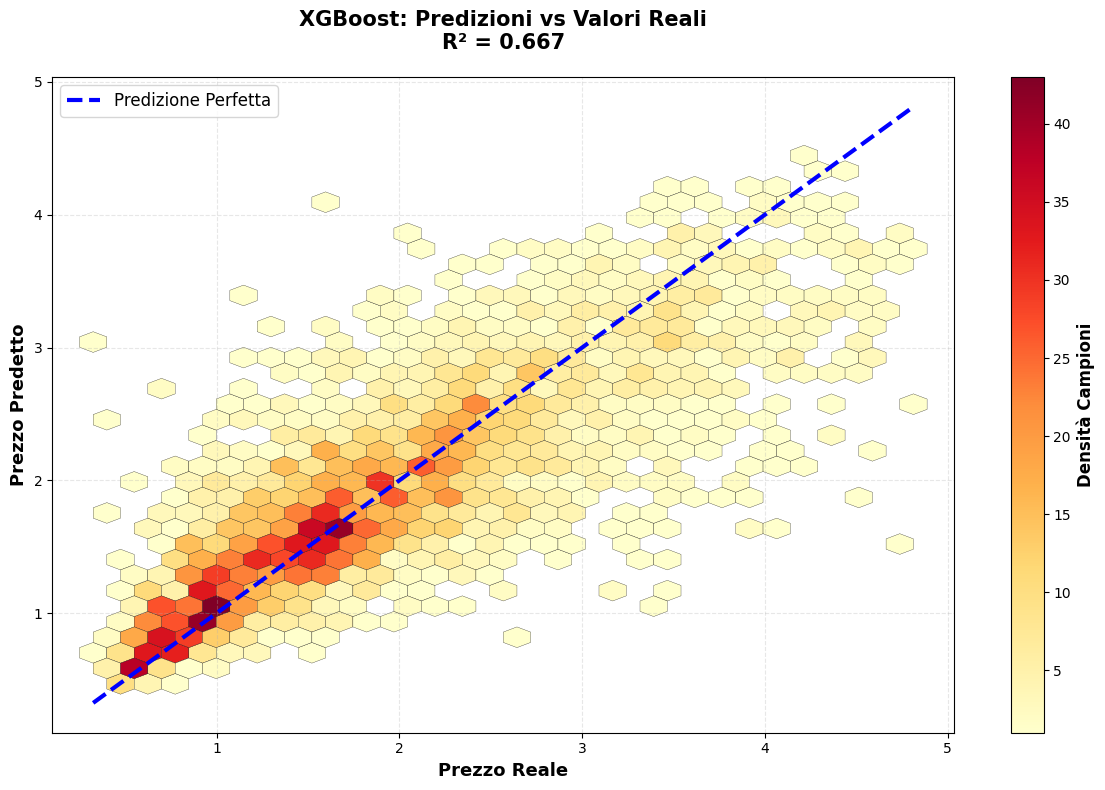

In [119]:
#visualizzazione della qualità del modello
fig, ax = plt.subplots(figsize=(12, 8))

# Hexbin plot con densità
hb = ax.hexbin(y_test, y_pred, gridsize=30, cmap='YlOrRd', 
               mincnt=1, edgecolors='black', linewidths=0.2)

# Linea di predizione 
ax.plot([y_test.min(), y_test.max()], 
        [y_test.min(), y_test.max()], 
        'b--', lw=3, label='Predizione Perfetta')


cb = plt.colorbar(hb, ax=ax)
cb.set_label('Densità Campioni', fontsize=12, fontweight='bold')

# Labels e titolo
ax.set_xlabel('Prezzo Reale', fontsize=13, fontweight='bold')
ax.set_ylabel('Prezzo Predetto', fontsize=13, fontweight='bold')
ax.set_title(f'XGBoost: Predizioni vs Valori Reali\nR² = {r2:.3f}', 
             fontsize=15, fontweight='bold', pad=20)

ax.legend(fontsize=12, loc='upper left')
ax.grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

In [ ]:
import sys
import subprocess

# Installa shap forzatamente
subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "shap", "--quiet"])


0

100%|===================| 3259/3263 [05:21<00:00]        

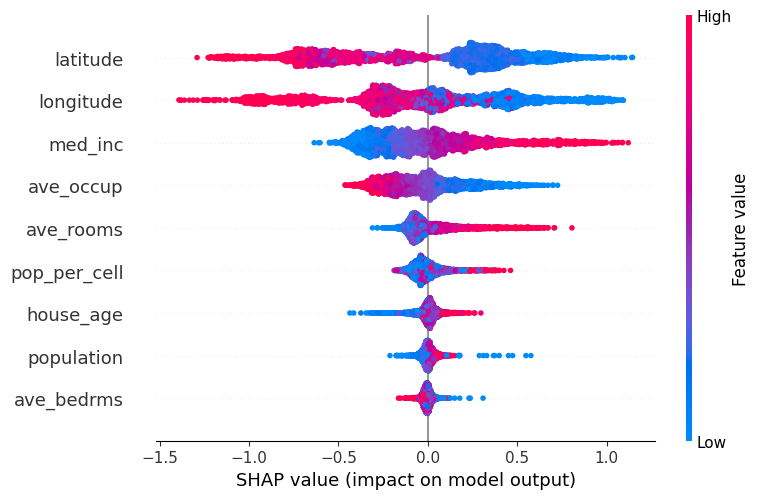

SHAP failed or not installed: name 'fi_df' is not defined


In [120]:
import shap

try:
    explainer = shap.Explainer(best_xgb_optuna, X_test) 
    shap_values = explainer(X_test)

    # Summary plot globale
    shap.summary_plot(shap_values, features=X_test, feature_names=X_numeric.columns, show=True)

    # Top feature per importanza
    top_feat = fi_df['feature'].iloc[0]  
    if top_feat.startswith('f'):
        idx = int(top_feat[1:])
        top_name = X_numeric.columns[idx]
    else:
        top_name = top_feat

    # Dependence plot
    shap.dependence_plot(top_name, shap_values.values, X_test, feature_names=X_numeric.columns, show=True)

except Exception as e:
    print('SHAP failed or not installed:', e)



--- CONFRONTO FINALE DEI MODELLI ---
                  Modello        R²      RMSE       MAE       MSE
4  XGBoost (Optuna Tuned)  0.849898  0.362226  0.246521  0.131207
3          XGBoost (Grid)  0.844749  0.368386  0.250918  0.135708
1           Random Forest  0.764714  0.453507  0.320778  0.205668
2           KNN Regressor  0.667345  0.539241  0.383549  0.290781
0       Linear Regression  0.643896  0.557923  0.420248  0.311278


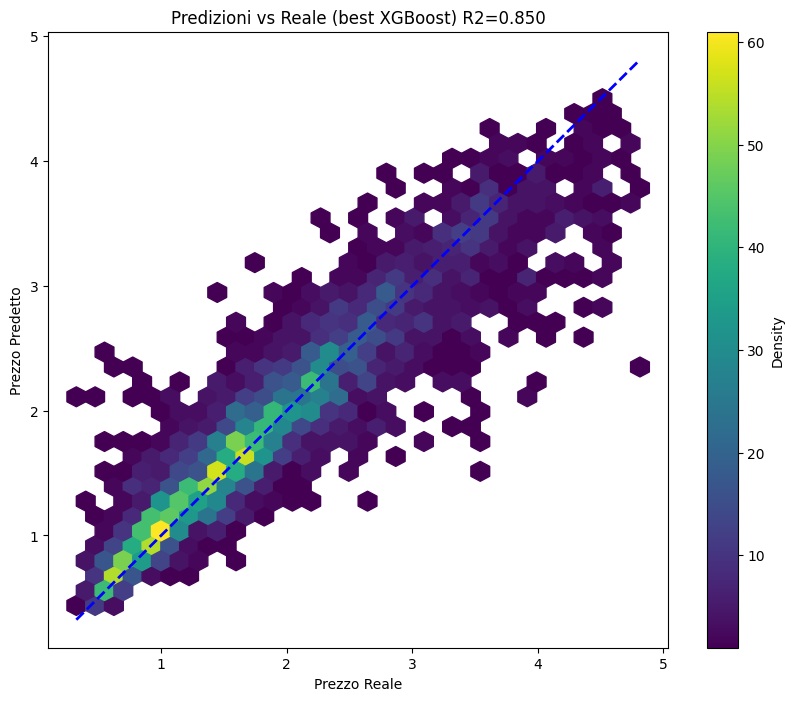

Notebook consolidated with XGBoost integrations: Optuna, early stopping, SHAP, importances, persistence.


In [ ]:

# -----------------------------
# 11. Final results and comparison
# -----------------------------
results_df = pd.DataFrame(results).drop_duplicates(subset=['Modello'], keep='last').sort_values(by='R²', ascending=False)
print('\n--- CONFRONTO FINALE DEI MODELLI ---')
print(results_df)


# Hexbin visualization of best model predictions
fig, ax = plt.subplots(figsize=(10,8))
y_pred_best = y_pred_tuned if 'y_pred_tuned' in globals() else y_pred_grid
hb = ax.hexbin(y_test, y_pred_best, gridsize=30, mincnt=1)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'b--', lw=2)
cb = plt.colorbar(hb, ax=ax)
cb.set_label('Density')
ax.set_xlabel('Prezzo Reale')
ax.set_ylabel('Prezzo Predetto')
ax.set_title(f'Predizioni vs Reale (best XGBoost) R2={r2_tuned:.3f}')
plt.show()


# -----------------------------
# End
# -----------------------------
print('Notebook consolidated with XGBoost integrations: Optuna, early stopping, SHAP, importances, persistence.')